# Deep Q-Network (DQN) for Pendulum Balancing
## Part B: Reinforcement Learning Implementation
**Group Member:** Kaung Myat San, Swam Htat Eung \
**Date:** July 31, 2025  
**Course:** ST1504 Deep Learning  

## Table of Contents
1. [Background Research and Problem Analysis](#1-background-research-and-problem-analysis)
2. [Environment Setup](#2-environment-setup)
3. [Implementing DQN Architecture](#3-implementing-dqn-architecture)
4. [Base-line Models](#4-Baseline-Models)
5. [Hyperparameter Optimization](#5-Hyperparameter-Optimization)

### Overview
This notebook implements and evaluates Deep Q-Network (DQN) architectures for solving the continuous control problem of pendulum balancing using OpenAI Gym's Pendulum-v0 environment.

---




## 1. Background Research and Problem Analysis

### 1.1 Problem Statement
Using Deep Q-Network to balance the pendulum which involves controlling a pendulum to maintain an upright position by applying appropriate torque. This is a continuous control problem in reinforcement learning where:

- **State Space**: 3-dimensional continuous space consisting of cos(θ), sin(θ), and angular velocity
    - **cos(θ)**: represents the horizontal position of pendulum
    - **sin(θ)**: represents the vertical position of pendulum
    - **angular velocity**- represents the direction and speed of rotation
- **Action Space**: Continuous torque values in range [-2.0, 2.0]
- **Objective**: Minimize the angle from vertical and control energy consumption
- **Reward Function**: Negative reward based on angle deviation and action magnitude


### 1.2 How to use DQN to balance the pendulum

To use a Deep Q-Network (DQN) for balancing the pendulum, the typical DQN algorithm must be adapted for continuous control, as the standard DQN is designed for discrete action spaces. Here’s how DQN can be applied to this problem:

#### 1. **Discretization of Action Space**
- Since DQN works with a discrete action space, the continuous range of possible torques (from -2.0 to 2.0) must be discretized into a fixed number of bins (e.g., 5, 9, or more discrete torque values).
- Each discrete action then corresponds to a specific torque value.

#### 2. **State Representation**
- The state is represented by the 3-dimensional continuous vector: `[cos(θ), sin(θ), angular velocity]`.
- This state vector is provided as input to the neural network.

#### 3. **Q-Network Architecture**
- A neural network (Q-network) takes the state as input and outputs a Q-value for each possible discrete action (torque).
- The network learns to predict the expected cumulative reward for each action given the current state.

#### 4. **Experience Replay**
- Transitions `(state, action, reward, next_state)` are stored in a replay buffer.
- During training, random batches are sampled from the buffer to break correlation between sequential experiences and to stabilize learning.

#### 5. **Target Network**
- A separate target network is used to compute the target Q-values for training stability.
- The weights of the target network are periodically updated to match the main Q-network.

#### 6. **Epsilon-Greedy Exploration**
- To balance exploration and exploitation, actions are selected using an epsilon-greedy strategy: with probability ε, a random action is chosen; otherwise, the action with the highest Q-value is selected.

#### 7. **Reward Calculation**
- The reward at each step is calculated based on how close the pendulum is to the upright position (minimizing angle deviation) and the magnitude of the applied torque (to minimize energy usage).

#### 8. **Training Loop**
- At each time step:
    1. Observe the current state.
    2. Select and apply a discrete action (torque).
    3. Observe the reward and next state.
    4. Store the transition in the replay buffer.
    5. Sample a batch of transitions and update the Q-network using the Bellman equation.
    6. Periodically update the target network.

#### 9. **Evaluation**
- After training, the learned policy (Q-network) is evaluated by running the pendulum environment and selecting the action with the highest Q-value at each state.

**Summary:**  
By discretizing the action space, DQN can be applied to the pendulum balancing task. The agent learns to select appropriate torques to keep the pendulum upright while minimizing unnecessary movements and energy expenditure. For higher performance, especially with fine-grained or fully continuous control, advanced algorithms like DDPG or SAC are often used, but DQN provides a straightforward and instructive baseline.


## 2. Environment Setup

### Importing Required Libraries

In [ ]:
# Import necessary libraries
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import collections
from collections import deque
import seaborn as sns
from IPython.display import clear_output
from typing import Optional, Tuple
import os, json
import csv
from typing import Dict, Any, List, Tuple, Optional

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set device (TensorFlow handles device placement automatically)
print(f"TensorFlow version: {tf.__version__}")

# Gym version check
print(f"Gym version: {gym.__version__}")

# Create and examine the Pendulum environment
env = gym.make('Pendulum-v0')
env.seed(SEED)
env.action_space.seed(SEED)
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Action space high: {env.action_space.high}")
print(f"Action space low: {env.action_space.low}")


TensorFlow version: 2.10.0
Gym version: 0.17.3
Observation space: Box(-8.0, 8.0, (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)
Action space high: [2.]
Action space low: [-2.]


### Discreting Action Space

As a DQN requres discrete actions, we will have to discretize the continuous action space [-2.0, 2.0].

In [2]:
class ActionDiscretizer:
    """
    Discretizes the continuous action space for DQN application.
    """
    def __init__(self, action_low, action_high, num_actions):
        self.action_low = action_low
        self.action_high = action_high
        self.num_actions = num_actions
        
        # Create discrete action values
        self.actions = np.linspace(action_low, action_high, num_actions)
        
    def discrete_to_continuous(self, discrete_action):
        """Convert discrete action index to continuous action value."""
        return np.array([self.actions[discrete_action]])
    
    def get_action_space_size(self):
        """Get the size of the discrete action space."""
        return self.num_actions
    
    def get_actions(self):
        """Get all possible action values."""
        return self.actions

# Test different discretization levels
discretization_levels = [5, 11, 21]

for num_actions in discretization_levels:
    discretizer = ActionDiscretizer(env.action_space.low[0], env.action_space.high[0], num_actions)
    print(f"\nDiscretization with {num_actions} actions:")
    print(f"Action values: {discretizer.get_actions()}")
    print(f"Action 0 maps to: {discretizer.discrete_to_continuous(0)}")
    print(f"Action {num_actions-1} maps to: {discretizer.discrete_to_continuous(num_actions-1)}")

# We'll start with 11 actions for a good balance between granularity and computational efficiency
NUM_ACTIONS = 11
action_discretizer = ActionDiscretizer(env.action_space.low[0], env.action_space.high[0], NUM_ACTIONS)
print(f"\nSelected discretization: {NUM_ACTIONS} actions")
print(f"Discrete actions: {action_discretizer.get_actions()}")


Discretization with 5 actions:
Action values: [-2. -1.  0.  1.  2.]
Action 0 maps to: [-2.]
Action 4 maps to: [2.]

Discretization with 11 actions:
Action values: [-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]
Action 0 maps to: [-2.]
Action 10 maps to: [2.]

Discretization with 21 actions:
Action values: [-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6
  0.8  1.   1.2  1.4  1.6  1.8  2. ]
Action 0 maps to: [-2.]
Action 20 maps to: [2.]

Selected discretization: 11 actions
Discrete actions: [-2.  -1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  2. ]


## 3. Implementing DQN Architecture

We aim to compare multiple DQN architectures and their advanced extensions to identify the most effective model.

### Architecture to evaluate:

#### 3.1 Standard DQN

- **Q-Network:** A neural network that takes the state as input and outputs Q-values for each of the `NUM_ACTIONS` discrete actions.
- **Experience Replay:** Stores transitions in a buffer and samples random batches for training to break temporal correlations.
- **Target Network:** A separate network for stable target Q-value computation, updated periodically.
- **Epsilon-Greedy Policy:** Balances exploration and exploitation by selecting random actions with probability ε.

#### 3.2 Double DQN

- **Motivation:** Reduces overestimation bias in Q-value updates.
- **Key Difference:** Uses the main network to select the best action, but the target network to evaluate its value.

#### 3.3 Dueling DQN

- **Architecture:** Splits the Q-network into two streams: one for estimating the state value and one for the advantage of each action.
- **Benefit:** Helps the agent learn which states are valuable, independent of the action taken.

#### 3.4 Prioritized Experience Replay

- **Improvement:** Samples important transitions more frequently based on their TD-error, speeding up learning.

---

### Implementing Standard DQN Architecture


#### 1. **Replay Buffer**

A replay buffer is used to store past experiences in the form of `(state, action, reward, next_state, done)`. It allows the agent to randomly sample mini-batches of experiences during training. This helps in breaking correlations between consecutive samples and improves training stability.

* **push**: Adds a new experience to the buffer.
* **sample**: Randomly selects a batch of experiences for training.
* **len**: Returns the current number of stored experiences.

In [3]:
class ReplayBuffer:
    def __init__(self, capacity, seed=SEED):
        self.buffer = collections.deque(maxlen=capacity)
        self.seed = seed
        if seed is not None:
            self._random = random.Random(seed)
        else:
            self._random = random

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = self._random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Test ReplayBuffer functionality with seed
buffer = ReplayBuffer(capacity=10, seed=SEED)
for i in range(12):
    buffer.push(i, i+1, i+2, i+3, False)
print(f"Buffer length (should be 10): {len(buffer)}")
sampled = buffer.sample(5)
print("Sampled batch shapes:", [arr.shape for arr in sampled])

Buffer length (should be 10): 10
Sampled batch shapes: [(5,), (5,), (5,), (5,), (5,)]



#### 2. **DQN Network**

The neural network used for the Q-function approximation has two hidden layers with 128 units each and ReLU activations. The final layer outputs raw Q-values for each possible action. This same architecture is used for both the online (current) Q-network and the target Q-network.

* **Input**: The environment's state.
* **Hidden layers**: Two fully connected layers with ReLU activation.
* **Output**: One value for each possible action (Q-values).

In [4]:
class DQN(tf.keras.Model):
    def __init__(self, state_dim, num_actions):
        super(DQN, self).__init__()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.out = tf.keras.layers.Dense(num_actions, activation=None)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)
    
# Test DQN network output shape
test_state = np.random.randn(1, env.observation_space.shape[0]).astype(np.float32)
model = DQN(env.observation_space.shape[0], NUM_ACTIONS)
output = model(test_state)
print("DQN output shape:", output.shape)  # Should be (1, NUM_ACTIONS)


DQN output shape: (1, 11)


#### 3. **DQN Agent**

This class manages the core reinforcement learning logic, including action selection, experience storage, training updates, and target network synchronization.

Initialization Parameters:

* **state\_dim**: Size of the input state vector.
* **num\_actions**: Number of possible discrete actions.
* **gamma**: Discount factor for future rewards.
* **lr**: Learning rate for the optimizer.
* **buffer\_size**: Capacity of the replay buffer.
* **batch\_size**: Number of experiences to sample for each training step.
* **epsilon\_start / epsilon\_end / epsilon\_decay**: Parameters for controlling exploration via the ε-greedy strategy.
* **target\_update\_freq**: Frequency of copying weights from the online Q-network to the target network.

Core Methods:

* **select\_action**: Chooses an action using an ε-greedy policy. With probability ε, a random action is taken (exploration). Otherwise, the agent selects the action with the highest predicted Q-value (exploitation).

* **store\_transition**: Saves the experience tuple into the replay buffer.

* **update**:

  1. Samples a mini-batch from the buffer.
  2. Computes the predicted Q-values and the target Q-values using the Bellman equation.
  3. Calculates the Mean Squared Error (MSE) loss between them.
  4. Applies gradient descent using Adam to update the Q-network weights.
  5. Decays ε over time to reduce exploration as training progresses.
  6. Periodically updates the target Q-network.


In [5]:
class DQNAgent:
    def __init__(self, state_dim, num_actions, gamma=0.99, lr=1e-3, buffer_size=100000, batch_size=64, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, target_update_freq=200):
        """
        Initialize the DQN agent with parameters for training.
        """
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.learn_step = 0

        self.q_net = DQN(state_dim, num_actions)
        self.target_q_net = DQN(state_dim, num_actions)
        self.q_net.build(input_shape=(None, state_dim))
        self.target_q_net.build(input_shape=(None, state_dim))
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
    
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state = np.expand_dims(state, axis=0).astype(np.float32)
        q_values = self.q_net(state)
        return np.argmax(q_values.numpy()[0])
    
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            next_q_values = self.target_q_net(next_states)
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            loss = tf.keras.losses.MSE(target_q, q_action)
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Test DQNAgent functionality
test_agent = DQNAgent(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    test_agent.store_transition(state, action, reward, next_state, done)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = test_agent.select_action(sample_state)
print("Selected action:", selected_action)

# Test update (should not error)
test_agent.update()
print("Update completed.")

Selected action: 4
Update completed.


--- 

### Implementing Double DQN Architecture

This class extends `DQNAgent` and overrides the `update` method to implement Double DQN.

#### **Main Idea:**

* Uses the **main Q-network** to select the best next action.
* Uses the **target Q-network** to evaluate the value of that action.
* This decoupling reduces overestimation of Q-values.

#### **Update Steps:**

1. Sample a batch from the replay buffer.
2. Get current Q-values for actions taken.
3. Use the main network to select the best next actions.
4. Use the target network to evaluate those actions.
5. Compute the target using the Bellman equation.
6. Calculate loss and update the main network.
7. Decay epsilon and periodically sync target network.

#### **Benefits:**

* Reduces overestimation bias.
* Improves learning stability and performance.




In [6]:
class DoubleDQNAgent(DQNAgent):
    """
    Double DQN agent that overrides the update method to use Double DQN logic.
    """
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)

        # Double DQN update
        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            
            # Main network selects best action for next state
            next_q_values_main = self.q_net(next_states)
            next_actions = tf.argmax(next_q_values_main, axis=1)
            
            # Target network evaluates the value of that action
            next_q_values_target = self.target_q_net(next_states)
            max_next_q = tf.reduce_sum(next_q_values_target * tf.one_hot(next_actions, self.num_actions), axis=1)
            
            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            loss = tf.keras.losses.MSE(target_q, q_action)
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Test DoubleDQNAgent functionality
double_dqn_agent = DoubleDQNAgent(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    double_dqn_agent.store_transition(state, action, reward, next_state, done)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = double_dqn_agent.select_action(sample_state)
print("Selected action (DoubleDQN):", selected_action)

# Test update (should not error)
double_dqn_agent.update()
print("DoubleDQNAgent update completed.")

Selected action (DoubleDQN): 1
DoubleDQNAgent update completed.


--- 

### Implementing Dueling DQN Architecture

#### **Motivation:**

Standard DQN treats all actions equally when estimating Q-values. Dueling DQN separates the estimation of the **state value** from the **advantage of each action**, allowing the agent to better evaluate states without relying on specific actions.

#### **Architecture:**

* Shared fully connected layers for feature extraction.
* Two separate streams:

  * **Value stream** estimates how good the current state is.
  * **Advantage stream** estimates the relative value of each action.
* Final Q-values are computed by combining value and advantage:

  * This helps the network focus on learning state values even when the choice of action doesn’t matter much.

#### **Benefits:**

* Improves learning efficiency in environments where actions have similar outcomes.
* Provides more robust Q-value estimates, especially in states with low action variance.





In [7]:
class DuelingDQN(tf.keras.Model):
    def __init__(self, state_dim, num_actions):
        super(DuelingDQN, self).__init__()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        # Value stream
        self.value_fc = tf.keras.layers.Dense(64, activation='relu')
        self.value = tf.keras.layers.Dense(1, activation=None)
        # Advantage stream
        self.advantage_fc = tf.keras.layers.Dense(64, activation='relu')
        self.advantage = tf.keras.layers.Dense(num_actions, activation=None)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        value = self.value(self.value_fc(x))
        advantage = self.advantage(self.advantage_fc(x))
        # Combine value and advantage streams
        q_vals = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        return q_vals
    
# Test DuelingDQN output shape
test_dueling_model = DuelingDQN(state_dim=env.observation_space.shape[0], num_actions=NUM_ACTIONS)
dueling_output = test_dueling_model(test_state)
print("DuelingDQN output shape:", dueling_output.shape)  # Should be (1, NUM_ACTIONS)

DuelingDQN output shape: (1, 11)


In [8]:
class DuelingDQNAgent(DQNAgent):
    """
    Dueling DQN agent using the DuelingDQN network architecture.
    Inherits core logic from DQNAgent but replaces the Q-network with DuelingDQN.
    """
    def __init__(self, state_dim, num_actions, gamma=0.99, lr=1e-3, buffer_size=100000, batch_size=64,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, target_update_freq=200):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.learn_step = 0

        self.q_net = DuelingDQN(state_dim, num_actions)
        self.target_q_net = DuelingDQN(state_dim, num_actions)
        self.q_net.build(input_shape=(None, state_dim))
        self.target_q_net.build(input_shape=(None, state_dim))
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)

# Example usage:
dueling_agent = DuelingDQNAgent(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100000,
    batch_size=64,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_freq=200
)
print("DuelingDQNAgent created.")
# Store some transitions in the buffer and test action selection and update
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    dueling_agent.store_transition(state, action, reward, next_state, done)

sample_state = env.observation_space.sample()
selected_action = dueling_agent.select_action(sample_state)
print("Selected action (DuelingDQN):", selected_action)

# Test update (should not error)
dueling_agent.update()
print("DuelingDQNAgent update completed.")

DuelingDQNAgent created.
Selected action (DuelingDQN): 7
DuelingDQNAgent update completed.


---

### Implementing Double + Dueling DQN Architecture

#### **Motivation:**

Double DQN reduces overestimation bias by decoupling action selection and evaluation, while Dueling DQN separately estimates the state value and advantage of each action. Combining both allows the agent to learn more accurate and stable Q-values.

#### **Architecture:**

* Shared fully connected layers extract features from the state.
* Two separate streams process these features:

  * **Value stream** estimates the overall value of the current state.
  * **Advantage stream** estimates how much better each action is compared to others.
* The final Q-values are computed by combining the value and advantage streams, enabling better learning even when some actions have similar effects.

#### **Benefits:**

* Reduces Q-value overestimation, improving stability and performance.
* Enhances learning efficiency in environments where the importance of actions varies.
* Provides more robust and precise Q-value estimates by leveraging the strengths of both Double and Dueling DQN methods.


In [9]:
# Double + Dueling DQN agent (without prioritized replay)
class DoubleDuelingDQNAgent(DoubleDQNAgent):
    def __init__(self, state_dim, num_actions, gamma=0.99, lr=1e-3, buffer_size=100000, batch_size=64,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, target_update_freq=200):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.learn_step = 0

        self.q_net = DuelingDQN(state_dim, num_actions)
        self.target_q_net = DuelingDQN(state_dim, num_actions)
        self.q_net.build(input_shape=(None, state_dim))
        self.target_q_net.build(input_shape=(None, state_dim))
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)

# Instantiate Double + Dueling DQN agent
double_dueling_dqn_agent = DoubleDuelingDQNAgent(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100000,
    batch_size=64,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_freq=200
)

# Test Double + Dueling DQN agent functionality
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    double_dueling_dqn_agent.replay_buffer.push(state, action, reward, next_state, done)

sample_state = env.observation_space.sample()
selected_action = double_dueling_dqn_agent.select_action(sample_state)
print("Selected action (Double+Dueling DQN):", selected_action)

# Add a simple update method for testing
def double_dueling_update(agent):
    if len(agent.replay_buffer) < agent.batch_size:
        return
    states, actions, rewards, next_states, dones = agent.replay_buffer.sample(agent.batch_size)
    states = states.astype(np.float32)
    next_states = next_states.astype(np.float32)
    rewards = rewards.astype(np.float32)
    dones = dones.astype(np.float32)
    actions = actions.astype(np.int32)

    with tf.GradientTape() as tape:
        q_values = agent.q_net(states)
        q_action = tf.reduce_sum(q_values * tf.one_hot(actions, agent.num_actions), axis=1)
        # Double DQN logic
        next_q_values_main = agent.q_net(next_states)
        next_actions = tf.argmax(next_q_values_main, axis=1)
        next_q_values_target = agent.target_q_net(next_states)
        max_next_q = tf.reduce_sum(next_q_values_target * tf.one_hot(next_actions, agent.num_actions), axis=1)
        target_q = rewards + agent.gamma * max_next_q * (1 - dones)
        loss = tf.keras.losses.MSE(target_q, q_action)
    grads = tape.gradient(loss, agent.q_net.trainable_variables)
    agent.optimizer.apply_gradients(zip(grads, agent.q_net.trainable_variables))
    # Epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    # Update target network
    agent.learn_step += 1
    if agent.learn_step % agent.target_update_freq == 0:
        agent.target_q_net.set_weights(agent.q_net.get_weights())

double_dueling_update(double_dueling_dqn_agent)
print("DoubleDuelingDQNAgent update completed.")

Selected action (Double+Dueling DQN): 6
DoubleDuelingDQNAgent update completed.


--- 

### Implementing Prioritized Replay Buffer

#### **Motivation:**

Standard replay samples uniformly—simple but inefficient, over-sampling low-TD-error transitions and under-sampling rare/high-error ones. PER samples proportional to priority (typically |TD error|), focusing updates where they matter and speeding value propagation. Bias from prioritized sampling is corrected with importance-sampling weights (β annealed toward 1), while α controls prioritization strength.

#### **Data Structure:**

- Weighted Experience by Priority:
  - Give each experience a score based on how important it is (its priority). Higher Score = higher chance to be picked.
  - Each Score equals to a single lottery ticket, therefore a higher score = higher change of getting picked
  - Use a special tree (sum-tree) to quickly pick a ticket and update counts, even with a huge buffer.

- Rank-based Experience by Importance:
  - Sort experiences from most to least important. Higher on the list = picked more often (but not always).

#### **Benefits:**

* Improves sample efficiency by focusing on informative, surprising, or rare transitions.
* Speeds up value propagation for sparse or delayed rewards.
* Orthogonal to Double and Dueling DQN; commonly used together for best results.






In [10]:
class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer using proportional prioritization.
    """
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha

    def push(self, state, action, reward, next_state, done, td_error=1.0):
        max_prio = self.priorities.max() if self.buffer else td_error
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max(max_prio, abs(td_error))
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error)

    def __len__(self):
        return len(self.buffer)

# Test PrioritizedReplayBuffer functionality
prioritized_buffer = PrioritizedReplayBuffer(capacity=10, alpha=0.6)
for i in range(12):
    state = np.random.randn(3)
    action = np.random.randint(0, NUM_ACTIONS)
    reward = np.random.randn()
    next_state = np.random.randn(3)
    done = np.random.choice([False, True])
    td_error = np.random.rand()
    prioritized_buffer.push(state, action, reward, next_state, done, td_error)

print(f"Prioritized buffer length (should be 10): {len(prioritized_buffer)}")
sampled = prioritized_buffer.sample(5, beta=0.4)
print("Sampled batch shapes:", [arr.shape for arr in sampled[:5]])
    

Prioritized buffer length (should be 10): 10
Sampled batch shapes: [(5, 3), (5,), (5,), (5, 3), (5,)]


### Implementing DQN agent with Prioritized Replay Buffer

#### Standard DQN

In [11]:
# Baseline: Standard DQN agent with prioritized replay buffer
class DQNAgentWithPrioritizedReplay(DQNAgent):
    def __init__(self, alpha=0.6, *args, **kwargs ):
        super().__init__(*args, **kwargs)
        self.replay_buffer = PrioritizedReplayBuffer(kwargs.get('buffer_size', 100000), alpha=alpha)

    def store_transition(self, state, action, reward, next_state, done, td_error=1.0):
        self.replay_buffer.push(state, action, reward, next_state, done, td_error)

    def update(self, beta=0.4):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, beta)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)
        weights = weights.astype(np.float32)

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            next_q_values = self.target_q_net(next_states)
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            td_errors = target_q - q_action
            loss = tf.reduce_mean(weights * tf.square(td_errors))
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))
        self.replay_buffer.update_priorities(indices, td_errors.numpy())

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Test DQNAgentWithPrioritizedReplay functionality
test_prioritized_agent = DQNAgentWithPrioritizedReplay(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    td_error = np.random.rand()
    test_prioritized_agent.store_transition(state, action, reward, next_state, done, td_error)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = test_prioritized_agent.select_action(sample_state)
print("Selected action (DQN+Prioritized):", selected_action)

# Test update (should not error)
test_prioritized_agent.update()
print("DQNAgentWithPrioritizedReplay update completed.")

Selected action (DQN+Prioritized): 8
DQNAgentWithPrioritizedReplay update completed.


#### Double DQN

In [12]:
# Double DQN agent with prioritized replay buffer
class DoubleDQNAgentWithPrioritizedReplay(DoubleDQNAgent):
    def __init__(self, alpha=0.6, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.replay_buffer = PrioritizedReplayBuffer(kwargs.get('buffer_size', 100000), alpha=alpha)

    def store_transition(self, state, action, reward, next_state, done, td_error=1.0):
        self.replay_buffer.push(state, action, reward, next_state, done, td_error)

    def update(self, beta=0.4):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, beta)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)
        weights = weights.astype(np.float32)

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)

            # Double DQN logic
            next_q_values_main = self.q_net(next_states)
            next_actions = tf.argmax(next_q_values_main, axis=1)
            next_q_values_target = self.target_q_net(next_states)
            max_next_q = tf.reduce_sum(next_q_values_target * tf.one_hot(next_actions, self.num_actions), axis=1)

            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            td_errors = target_q - q_action
            loss = tf.reduce_mean(weights * tf.square(td_errors))
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))
        self.replay_buffer.update_priorities(indices, td_errors.numpy())

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Test DoubleDQNAgentWithPrioritizedReplay functionality
test_double_prioritized_agent = DoubleDQNAgentWithPrioritizedReplay(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    td_error = np.random.rand()
    test_double_prioritized_agent.store_transition(state, action, reward, next_state, done, td_error)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = test_double_prioritized_agent.select_action(sample_state)
print("Selected action (DoubleDQN+Prioritized):", selected_action)

# Test update (should not error)
test_double_prioritized_agent.update()
print("DoubleDQNAgentWithPrioritizedReplay update completed.")

Selected action (DoubleDQN+Prioritized): 9
DoubleDQNAgentWithPrioritizedReplay update completed.


#### Dueling DQN

In [13]:
# Dueling DQN agent with prioritized replay buffer
class DuelingDQNAgentWithPrioritizedReplay(DuelingDQNAgent):
    def __init__(self, alpha=0.6, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.replay_buffer = PrioritizedReplayBuffer(kwargs.get('buffer_size', 100000), alpha=alpha)

    def store_transition(self, state, action, reward, next_state, done, td_error=1.0):
        self.replay_buffer.push(state, action, reward, next_state, done, td_error)

    def update(self, beta=0.4):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, beta)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)
        weights = weights.astype(np.float32)

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            next_q_values = self.target_q_net(next_states)
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            td_errors = target_q - q_action
            loss = tf.reduce_mean(weights * tf.square(td_errors))
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))
        self.replay_buffer.update_priorities(indices, td_errors.numpy())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

            
# Test DuelingDQNAgentWithPrioritizedReplay functionality
test_dueling_prioritized_agent = DuelingDQNAgentWithPrioritizedReplay(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    td_error = np.random.rand()
    test_dueling_prioritized_agent.store_transition(state, action, reward, next_state, done, td_error)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = test_dueling_prioritized_agent.select_action(sample_state)
print("Selected action (DuelingDQN+Prioritized):", selected_action)

# Test update (should not error)
test_dueling_prioritized_agent.update()
print("DuelingDQNAgentWithPrioritizedReplay update completed.")

Selected action (DuelingDQN+Prioritized): 3
DuelingDQNAgentWithPrioritizedReplay update completed.


#### Double + Dueling DQN

In [14]:
# Double + Dueling DQN agent with prioritized replay buffer
class DoubleDuelingDQNAgentWithPrioritizedReplay(DoubleDuelingDQNAgent):
    def __init__(self, alpha=0.6, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.replay_buffer = PrioritizedReplayBuffer(kwargs.get('buffer_size', 100000), alpha=alpha)

    def store_transition(self, state, action, reward, next_state, done, td_error=1.0):
        self.replay_buffer.push(state, action, reward, next_state, done, td_error)

    def update(self, beta=0.4):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, beta)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)
        weights = weights.astype(np.float32)

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            # Double DQN logic
            next_q_values_main = self.q_net(next_states)
            next_actions = tf.argmax(next_q_values_main, axis=1)
            next_q_values_target = self.target_q_net(next_states)
            max_next_q = tf.reduce_sum(next_q_values_target * tf.one_hot(next_actions, self.num_actions), axis=1)
            target_q = rewards + self.gamma * max_next_q * (1 - dones)
            td_errors = target_q - q_action
            loss = tf.reduce_mean(weights * tf.square(td_errors))
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))
        self.replay_buffer.update_priorities(indices, td_errors.numpy())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.learn_step += 1
        if self.learn_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Test Double + Dueling DQN agent with prioritized replay buffer
test_double_dueling_prioritized_agent = DoubleDuelingDQNAgentWithPrioritizedReplay(
    state_dim=env.observation_space.shape[0],
    num_actions=NUM_ACTIONS,
    gamma=0.99,
    lr=1e-3,
    buffer_size=100,
    batch_size=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.99,
    target_update_freq=10,
    alpha=0.6
)

# Store some transitions in the buffer
for _ in range(10):
    state = env.observation_space.sample()
    action = np.random.randint(NUM_ACTIONS)
    reward = np.random.randn()
    next_state = env.observation_space.sample()
    done = np.random.choice([False, True])
    td_error = np.random.rand()
    test_double_dueling_prioritized_agent.store_transition(state, action, reward, next_state, done, td_error)

# Test action selection
sample_state = env.observation_space.sample()
selected_action = test_double_dueling_prioritized_agent.select_action(sample_state)
print("Selected action (Double+Dueling DQN+Prioritized):", selected_action)

# Test update (should not error)
test_double_dueling_prioritized_agent.update()
print("DoubleDuelingDQNAgentWithPrioritizedReplay update completed.")

Selected action (Double+Dueling DQN+Prioritized): 3
DoubleDuelingDQNAgentWithPrioritizedReplay update completed.


---

## 4. Baseline Models

In this section, we evaluate and compare the following DQN-based architectures **with and without Prioritized Replay Buffer**:

### Without Prioritized Replay Buffer

- **Standard DQN**  
  Basic Deep Q-Network with uniform experience replay and a target network.

- **Double DQN**  
  Reduces overestimation bias by decoupling action selection and evaluation, using standard replay buffer.

- **Dueling DQN**  
  Separates state value and action advantage streams for more robust Q-value learning, using standard replay buffer.

- **Double + Dueling DQN**  
  Combines the strengths of Double DQN and Dueling DQN, still using standard replay buffer.


### With Prioritized Replay Buffer

- **Standard DQN + Prioritized Replay**  
  Incorporates prioritized sampling to focus learning on more significant transitions.

- **Double DQN + Prioritized Replay**  
  Double DQN architecture with prioritized experience replay.

- **Dueling DQN + Prioritized Replay**  
  Dueling network architecture utilizing prioritized replay buffer.

- **Double + Dueling DQN + Prioritized Replay**  
  Combines Double DQN, Dueling DQN, and Prioritized Replay Buffer to further enhance learning efficiency.

<br>
<br>

> **Note:**  
> For fair comparison, all models are trained under the same settings except for the replay buffer mechanism.



### DQN Architecture (Baseline Models)

In [15]:

results = {} # initialize results dictionary


In [ ]:
# Define agent configs and classes
agent_configs = [
    {
        'name': 'standard_dqn',
        'agent_class': DQNAgent,
        'prioritized': False
    },
    {
        'name': 'double_dqn',
        'agent_class': DoubleDQNAgent,
        'prioritized': False
    },
    {
        'name': 'dueling_dqn',
        'agent_class': lambda **kwargs: DuelingDQNAgentWithPrioritizedReplay(**kwargs) if kwargs.pop('prioritized', False) else DQNAgent(**kwargs),  # fallback for dueling
        'prioritized': False
    },
    {
        'name': 'double_dueling_dqn',
        'agent_class': DoubleDuelingDQNAgent,
        'prioritized': False
    },
    {
        'name': 'standard_dqn_prioritized',
        'agent_class': DQNAgentWithPrioritizedReplay,
        'prioritized': True
    },
    {
        'name': 'double_dqn_prioritized',
        'agent_class': DoubleDQNAgentWithPrioritizedReplay,
        'prioritized': True
    },
    {
        'name': 'dueling_dqn_prioritized',
        'agent_class': DuelingDQNAgentWithPrioritizedReplay,
        'prioritized': True
    },
    {
        'name': 'double_dueling_dqn_prioritized',
        'agent_class': DoubleDuelingDQNAgentWithPrioritizedReplay,
        'prioritized': True
    }
]

num_episodes = 20  # For demonstration
eval_episodes = 20  # Number of episodes for evaluation

for config in agent_configs:
    print(f"Training {config['name']} ...")
    agent_kwargs = dict(
        state_dim=env.observation_space.shape[0],
        num_actions=NUM_ACTIONS,
        gamma=0.99,
        lr=1e-3,
        buffer_size=100000,
        batch_size=64,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        target_update_freq=200
    )
    if config['prioritized']:
        agent = config['agent_class'](**agent_kwargs)
    else:
        # For dueling_dqn without prioritized, use DuelingDQN architecture with standard buffer
        if config['name'] == 'dueling_dqn':
            agent = DuelingDQNAgentWithPrioritizedReplay(**agent_kwargs)
        else:
            agent = config['agent_class'](**agent_kwargs)
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action_idx = agent.select_action(state)
            action = action_discretizer.discrete_to_continuous(action_idx)
            next_state, reward, done, _ = env.step(action)
            if config['prioritized']:
                agent.store_transition(state, action_idx, reward, next_state, done, td_error=1.0)
                agent.update(beta=0.4)
            else:
                agent.store_transition(state, action_idx, reward, next_state, done)
                agent.update()
            state = next_state
            episode_reward += reward
        rewards.append(episode_reward)

    
    eval_rewards = []
    agent.epsilon = 0.0  # Pure exploitation
    for _ in range(eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action_idx = agent.select_action(state)
            action = action_discretizer.discrete_to_continuous(action_idx)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward
        eval_rewards.append(episode_reward)
    results[config['name']] = {'rewards': rewards, 'parameters': agent_kwargs, 'eval_rewards': eval_rewards}  

print("Training complete. Results keys:", list(results.keys()))

Training standard_dqn ...
Training double_dqn ...
Training dueling_dqn ...
Training double_dueling_dqn ...
Training standard_dqn_prioritized ...
Training double_dqn_prioritized ...
Training dueling_dqn_prioritized ...
Training double_dueling_dqn_prioritized ...
Training complete. Results keys: ['standard_dqn', 'double_dqn', 'dueling_dqn', 'double_dueling_dqn', 'standard_dqn_prioritized', 'double_dqn_prioritized', 'dueling_dqn_prioritized', 'double_dueling_dqn_prioritized']


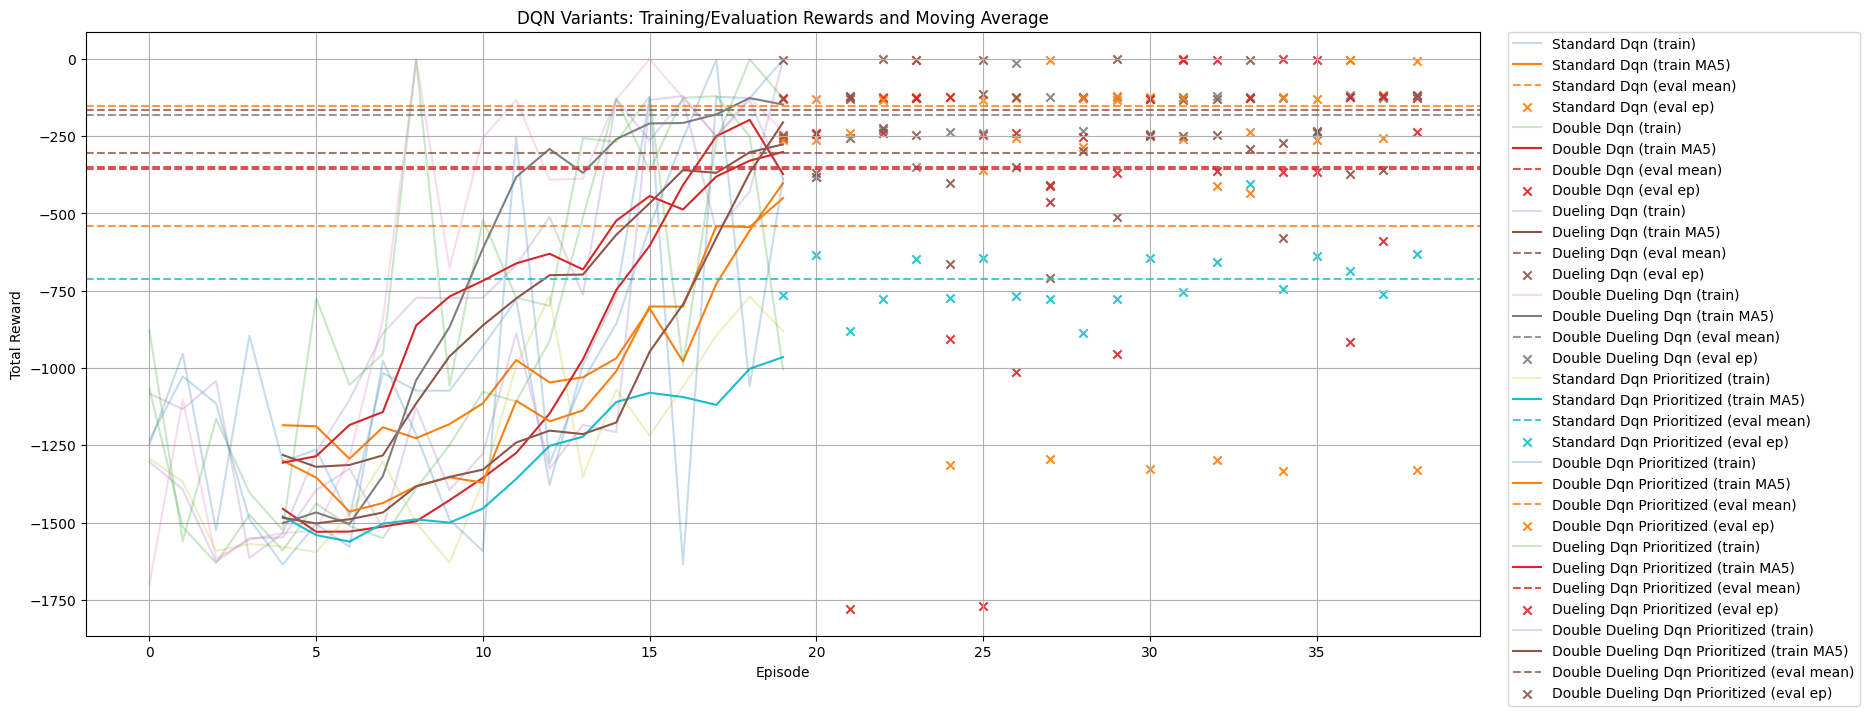

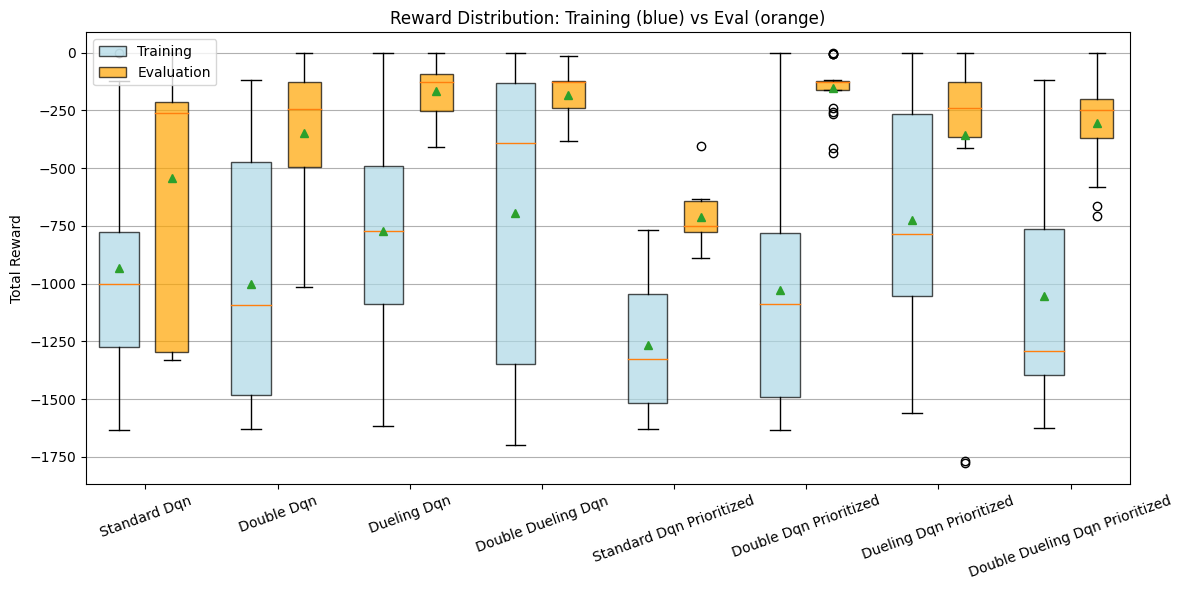


Best Hyperparameters per Agent:

standard_dqn:
  state_dim: 3
  num_actions: 11
  gamma: 0.99
  lr: 0.001
  buffer_size: 100000
  batch_size: 64
  epsilon_start: 1.0
  epsilon_end: 0.05
  epsilon_decay: 0.995
  target_update_freq: 200

double_dqn:
  state_dim: 3
  num_actions: 11
  gamma: 0.99
  lr: 0.001
  buffer_size: 100000
  batch_size: 64
  epsilon_start: 1.0
  epsilon_end: 0.05
  epsilon_decay: 0.995
  target_update_freq: 200

dueling_dqn:
  state_dim: 3
  num_actions: 11
  gamma: 0.99
  lr: 0.001
  buffer_size: 100000
  batch_size: 64
  epsilon_start: 1.0
  epsilon_end: 0.05
  epsilon_decay: 0.995
  target_update_freq: 200

double_dueling_dqn:
  state_dim: 3
  num_actions: 11
  gamma: 0.99
  lr: 0.001
  buffer_size: 100000
  batch_size: 64
  epsilon_start: 1.0
  epsilon_end: 0.05
  epsilon_decay: 0.995
  target_update_freq: 200

standard_dqn_prioritized:
  state_dim: 3
  num_actions: 11
  gamma: 0.99
  lr: 0.001
  buffer_size: 100000
  batch_size: 64
  epsilon_start: 1.0
  epsi

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dqn_results(results, window=3, show_hyperparams=True):
    """
    Plot detailed reward curves and statistics for DQN variants with hypertuning.
    Args:
        results (dict): Dictionary with agent names as keys and dicts with
                        'rewards', 'eval_rewards', and 'parameters' as values.
        window (int): Window size for moving average smoothing.
        show_hyperparams (bool): If True, print best hyperparameters.
    """
    plt.figure(figsize=(15, 7))
    # 1. Training curve with moving average, Eval mean as a horizontal line, and eval points
    for name, result in results.items():
        rewards = np.array(result['rewards'])
        eval_rewards = np.array(result.get('eval_rewards', []))
        # Training reward curve
        plt.plot(rewards, alpha=0.25, label=f"{name.replace('_', ' ').title()} (train)")
        # Moving average
        if len(rewards) >= window:
            mov_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(window-1, len(rewards)), mov_avg, label=f"{name.replace('_', ' ').title()} (train MA{window})")
        # Eval mean line
        if eval_rewards.size > 0:
            eval_mean = np.mean(eval_rewards)
            plt.axhline(eval_mean, linestyle='--', color=plt.gca().lines[-1].get_color(),
                        alpha=0.8, label=f"{name.replace('_', ' ').title()} (eval mean)")
            # Individual eval points
            plt.scatter(
                np.linspace(len(rewards)-1, len(rewards)+len(eval_rewards)-2, len(eval_rewards)),
                eval_rewards,
                marker='x', color=plt.gca().lines[-1].get_color(), alpha=0.9,
                label=f"{name.replace('_', ' ').title()} (eval ep)"
            )
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Variants: Training/Evaluation Rewards and Moving Average')
    plt.grid(True)
    plt.tight_layout()
    # Place legend outside the plot to the right
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

    # 2. Boxplots for training and eval rewards
    plt.figure(figsize=(12, 6))
    train_data = [np.array(result['rewards']) for result in results.values()]
    eval_data = [np.array(result.get('eval_rewards', [])) for result in results.values()]
    labels = [name.replace('_', ' ').title() for name in results.keys()]
    positions1 = np.arange(len(labels))*2.0
    positions2 = positions1 + 0.8
    b1 = plt.boxplot(train_data, positions=positions1, widths=0.6, patch_artist=True,
                     showmeans=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
    b2 = plt.boxplot(eval_data, positions=positions2, widths=0.5, patch_artist=True,
                     showmeans=True, boxprops=dict(facecolor='orange', alpha=0.7))
    for patch in b1['boxes']: patch.set_facecolor('lightblue')
    for patch in b2['boxes']: patch.set_facecolor('orange')
    plt.xticks(positions1 + 0.4, labels, rotation=20)
    plt.ylabel('Total Reward')
    plt.title('Reward Distribution: Training (blue) vs Eval (orange)')
    plt.legend([b1["boxes"][0], b2["boxes"][0]], ["Training", "Evaluation"], loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # 3. Optionally print best hyperparameters found for each agent
    if show_hyperparams:
        print("\nBest Hyperparameters per Agent:")
        for name, result in results.items():
            print(f"\n{name}:")
            for k, v in result['parameters'].items():
                print(f"  {k}: {v}")

# Usage:
plot_dqn_results(results, window=5)

### Baseline Model Comparison and Decision (Line Graph & Box Plot)

#### What we compared
- Baselines: Standard DQN, Double DQN, Dueling DQN, and Double+Dueling.
- Each with two buffers: Uniform replay vs Prioritized Experience Replay (PER).
- Metrics: learning curves (training and eval means) and reward distributions (boxplots).
- Note: Rewards are negative; higher (closer to 0) is better.

#### Learning curves & Evaluation Score (Line Graph)
- Speed:
    - PER variants climb earlier and more consistently
    - uniform replay lags.
- Plateaus:
    - The strongest plateaus tend to be among PER models, with Double/Dueling/Double-Dueling + PER near the top.
- Stability:
    - PER lines and eval markers show tighter clustering (less variance) than uniform counterparts.
- Baseline deltas:
    - Double reduces overestimation
    - Dueling improves value/advantage decomposition
    - combining them with PER compounds gains.

#### Training and Evaluation Reward Distributino (Box Plot)
- Best central performance
  - Double Dueling DQN shows the highest evaluation central tendency (median/mean closest to 0), indicating the strongest typical performance across runs.

- Variance vs. stability
  - Its evaluation box (IQR) is small—among the tightest on the chart—implying low variance; only Double DQN Prioritized appears slightly tighter.
  - However, Double DQN Prioritized exhibits noticeably more outliers, suggesting occasional poor episodes/seeds despite its tight core distribution.

- Interpretation
  - Double Dueling DQN: best overall evaluation score with consistent returns (low variance, few extreme failures).
  - Double DQN Prioritized: competitive typical performance but higher instability (more outliers).

####  Conclusion
- No finalized “best” model:
    - Although PER variants—especially Double/Dueling/Double‑Dueling + PER—look stronger, the overlapping distributions and variability prevent a firm choice.

#### To Do
- Hypertuned All variants using a Optimal Hyperparameter Tuning Order
- Evaluate each model's performance
      - Selection metrics: median eval over last K evaluations, AUC of learning curve (sample efficiency), stability via IQR.
- Choose top variant based on Evaluation Metric after hyper-tuning

---

## 5. Hyperparameter Optimization

### DQN Architecture (Standard Replay Buffer)

#### **Optimal Hyperparameter Tuning Order (by impact):**

**1st Priority: Learning Rate (`lr`)**  
- **Current**: `1e-3`
- **Why first**: Most critical for convergence and stability
- **Suggested range**: `[1e-4, 5e-4, 1e-3, 2e-3, 5e-3]`
- **Impact**: Wrong learning rate can prevent learning entirely or cause instability

**2nd Priority: Epsilon Decay Rate (`epsilon_decay`)**  
- **Current**: `0.995`
- **Why second**: Controls exploration-exploitation balance over time
- **Suggested range**: `[0.99, 0.995, 0.999, 0.9995]`
- **Impact**: Too fast decay = premature exploitation; too slow = prolonged random behavior

**3rd Priority: Target Network Update Frequency (`target_update_freq`)**  
- **Current**: `200`
- **Why third**: Affects training stability significantly
- **Suggested range**: `[100, 200, 500, 1000]`
- **Impact**: Too frequent = unstable targets; too rare = outdated targets

**4th Priority: Batch Size (`batch_size`)**  
- **Current**: `64`
- **Why fourth**: Affects sample efficiency and gradient quality
- **Suggested range**: `[32, 64, 128, 256]`
- **Impact**: Larger batches = more stable gradients but slower learning

**5th Priority: Discount Factor (`gamma`)**  
- **Current**: `0.99`
- **Why fifth**: Task-dependent but less critical for initial performance
- **Suggested range**: `[0.95, 0.99, 0.995, 0.999]`
- **Impact**: Controls how much agent values future rewards

**6th Priority: Buffer Size (`buffer_size`)**  
- **Current**: `100,000`
- **Why sixth**: Usually sufficient; mainly affects memory usage
- **Suggested range**: `[50000, 100000, 200000]`
- **Impact**: Larger buffers = more diverse experiences but more memory

**7th Priority: Epsilon End Value (`epsilon_end`)**  
- **Current**: `0.05`
- **Why seventh**: Fine-tunes minimum exploration level
- **Suggested range**: `[0.01, 0.05, 0.1, 0.2]`
- **Impact**: Lower values = less exploration in later stages

**8th Priority: Action Space Discretization (`num_actions`)**  
- **Current**: `11`
- **Why lower**: Environment-specific; affects action granularity
- **Suggested range**: `[7, 11, 15, 21]`
- **Impact**: More actions = finer control but larger action space

**Tuning Strategy:**  
1. Start with learning rate - try 3-4 values and pick the most stable
2. Fix learning rate, tune epsilon decay - find exploration-exploitation balance  
3. With those fixed, tune target update frequency - look for stable Q-values
4. Continue sequentially through remaining parameters
5. For action discretization, test separately as it affects environment interaction

**Key Metrics to Monitor:**  
- **Episode rewards** (primary metric)
- **Q-value stability** (should increase over time)  
- **Loss convergence** (should decrease initially then stabilize)
- **Epsilon decay curve** (should reach minimum smoothly)
- **Action distribution** (should become less random over time)

In [16]:
from itertools import product
import numpy as np

def grid_search_hyperparams(param_grid):
    """
    Generate all combinations of hyperparameters from the grid.
    """
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for v in product(*values):
        yield dict(zip(keys, v))

def hypertune_generic_dqn(
    agent_class,
    env, 
    param_grid, 
    num_episodes=20, 
    eval_episodes=5, 
    seed=42,
    agent_kwargs_extra=None
):
    """
    Generic grid search hypertuning for DQN variants.
    agent_class: class of the agent to instantiate (DQNAgent, DoubleDQNAgent, DuelingDQNAgent, DoubleDuelingDQNAgent)
    agent_kwargs_extra: dict of extra kwargs to pass to agent_class (optional)
    Returns the best model's training rewards, evaluation rewards, and hyperparameters.
    """
    if agent_kwargs_extra is None:
        agent_kwargs_extra = {}
    np.random.seed(seed)
    best_params = {}
    best_result = None
    best_avg_eval_reward = -np.inf
    default_params = {
        'lr': 1e-3,
        'epsilon_decay': 0.995,
        'target_update_freq': 200,
        'batch_size': 64,
        'gamma': 0.99,
        'buffer_size': 100000,
        'epsilon_start': 1.0,
        'epsilon_end': 0.05,
        'state_dim': env.observation_space.shape[0],
        'num_actions': 11 if not hasattr(env, 'NUM_ACTIONS') else env.NUM_ACTIONS
    }
    tuning_keys = [k for k in [
        'lr', 'epsilon_decay', 'target_update_freq', 'batch_size', 'gamma',
        'buffer_size', 'epsilon_end', 'num_actions'
    ] if k in param_grid]
    for i, key in enumerate(tuning_keys):
        print(f"Tuning {key} ...")
        grid = {k: [best_params.get(k, default_params[k])] for k in tuning_keys[:i]}
        grid[key] = param_grid[key]
        grid.update({k: [default_params[k]] for k in tuning_keys[i+1:]})
        best_local_avg_eval_reward = -np.inf
        best_local_params = None
        best_local_result = None
        for params in grid_search_hyperparams(grid):
            num_actions = params.get('num_actions', default_params['num_actions'])
            discretizer = ActionDiscretizer(
                env.action_space.low[0], env.action_space.high[0], num_actions
            )
            agent_kwargs = dict(
                state_dim=default_params['state_dim'],
                num_actions=num_actions,
                lr=params['lr'],
                buffer_size=params['buffer_size'],
                batch_size=params['batch_size'],
                epsilon_start=default_params['epsilon_start'],
                epsilon_end=params.get('epsilon_end', default_params['epsilon_end']),
                epsilon_decay=params['epsilon_decay'],
                target_update_freq=params['target_update_freq'],
            )
            agent_kwargs.update(agent_kwargs_extra)
            agent = agent_class(**agent_kwargs)
            rewards = []
            for ep in range(num_episodes):
                state = env.reset()
                done = False
                ep_reward = 0
                while not done:
                    action_idx = agent.select_action(state)
                    action = discretizer.discrete_to_continuous(action_idx)
                    next_state, reward, done, _ = env.step(action)
                    # Support both .store_transition and .replay_buffer.push
                    if hasattr(agent, "store_transition"):
                        agent.store_transition(state, action_idx, reward, next_state, done)
                    elif hasattr(agent, "replay_buffer") and hasattr(agent.replay_buffer, "push"):
                        agent.replay_buffer.push(state, action_idx, reward, next_state, done)
                    agent.update()
                    state = next_state
                    ep_reward += reward
                rewards.append(ep_reward)
            # --- Evaluation ---
            eval_rewards = []
            agent.epsilon = 0.0
            for _ in range(eval_episodes):
                state = env.reset()
                done = False
                ep_reward = 0
                while not done:
                    action_idx = agent.select_action(state)
                    action = discretizer.discrete_to_continuous(action_idx)
                    next_state, reward, done, _ = env.step(action)
                    state = next_state
                    ep_reward += reward
                eval_rewards.append(ep_reward)
            avg_eval_reward = np.mean(eval_rewards)
            print(f"Params: {params}, Avg Eval Reward: {avg_eval_reward:.2f}")
            if avg_eval_reward > best_local_avg_eval_reward:
                best_local_avg_eval_reward = avg_eval_reward
                best_local_params = params.copy()
                best_local_result = {
                    'rewards': rewards,
                    'parameters': params.copy(),
                    'eval_rewards': eval_rewards
                }
        best_params.update(best_local_params)
        best_result = best_local_result
        best_avg_eval_reward = best_local_avg_eval_reward
        print(f"Best {key}: {best_local_params[key]}, Eval Reward: {best_local_avg_eval_reward:.2f}\n")
    print("Best hyperparameters found:", best_params)
    print("Best average eval reward:", best_avg_eval_reward)
    return best_result

# Training and hypertuning DQN variants

param_grid = {
    'lr': [1e-4, 5e-4, 1e-3, 2e-3, 5e-3],
    'epsilon_decay': [0.99, 0.995, 0.999, 0.9995],
    'target_update_freq': [100, 200, 500, 1000],
    'batch_size': [32, 64, 128, 256],
    'gamma': [0.95, 0.99, 0.995, 0.999],
    'buffer_size': [50000, 100000, 200000],
    'epsilon_end': [0.01, 0.05, 0.1, 0.2],
    'num_actions': [7, 11, 15, 21]
}

print("Starting hypertuning for DQN variants...")

print("Hypertuning Standard DQN...")
result = hypertune_generic_dqn(DQNAgent, env, param_grid, num_episodes=20, eval_episodes=20)
results['standard_dqn_hypertuned'] = result
print("Standard DQN hypertuning completed.\n")

print("Hypertuning Double DQN...")
result = hypertune_generic_dqn(DoubleDQNAgent, env, param_grid, num_episodes=20, eval_episodes=20)
results['double_dqn_hypertuned'] = result
print("Double DQN hypertuning completed.\n")

print("Hypertuning Dueling DQN...")
result = hypertune_generic_dqn(DuelingDQNAgent, env, param_grid, num_episodes=20, eval_episodes=20)
results['dueling_dqn_hypertuned'] = result
print("Dueling DQN hypertuning completed.\n")

print("Hypertuning Double Dueling DQN...")
result = hypertune_generic_dqn(DoubleDuelingDQNAgent, env, param_grid, num_episodes=20, eval_episodes=20)
results['double_dueling_dqn_hypertuned'] = result
print("Double Dueling DQN hypertuning completed.\n")

Starting hypertuning for DQN variants...
Hypertuning Standard DQN...
Tuning lr ...
Params: {'lr': 0.0001, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -1514.81
Params: {'lr': 0.0005, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -1238.80
Params: {'lr': 0.001, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -401.79
Params: {'lr': 0.002, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -221.31
Params: {'lr': 0.005, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'eps

### DQN Architecture (Prioritized Replay Buffer)

#### **Optimal Hyperparameter Tuning Order (by impact):**

**1st Priority: Learning Rate (`lr`)**  
- **Current**: `1e-3`  
- **Why first**: Still the most sensitive parameter; affects how quickly (and stably) the Q-network learns from high-priority transitions  
- **Suggested range**: `[1e-4, 5e-4, 1e-3, 2e-3, 5e-3]`  
- **Impact**: Too high can cause divergence or overfit to high-error samples; too low can underutilize prioritized sampling

**2nd Priority: Prioritization Exponent (`alpha`)**  
- **Current**: `0.6`  
- **Why second**: Controls how strongly sampling is biased toward high TD-error transitions  
- **Suggested range**: `[0.3, 0.5, 0.6, 0.7, 0.8]`  
- **Impact**: Higher = more focus on high-error, faster learning but more bias; Lower = closer to uniform, slower learning but less bias

**3rd Priority: Importance Sampling Exponent (`beta`)**  
- **Current**: `0.4` (usually annealed to `1.0`)  
- **Why third**: Corrects for bias from prioritized sampling during learning  
- **Suggested range**: `[0.4, 0.5, 0.7, 1.0]` (often linearly annealed over training)  
- **Impact**: Too low = more bias in updates; too high = slower learning, but more correct value estimates

**4th Priority: Epsilon Decay Rate (`epsilon_decay`)**  
- **Current**: `0.995`  
- **Why fourth**: Affects how quickly random exploration is reduced; can interact with prioritized replay (since buffer samples important transitions)  
- **Suggested range**: `[0.99, 0.995, 0.999, 0.9995]`  
- **Impact**: Too fast = not enough diverse data in buffer; too slow = suboptimal policy for longer

**5th Priority: Target Network Update Frequency (`target_update_freq`)**  
- **Current**: `200`  
- **Why fifth**: Still crucial for stability, especially with more aggressive updates from prioritized samples  
- **Suggested range**: `[100, 200, 500, 1000]`  
- **Impact**: Too frequent = instability; too rare = slow convergence

**6th Priority: Batch Size (`batch_size`)**  
- **Current**: `64`  
- **Why sixth**: Larger batches average out prioritized weights and errors more, possibly smoothing learning  
- **Suggested range**: `[32, 64, 128, 256]`  
- **Impact**: Too small = noisy, unstable updates; too large = less responsive

**7th Priority: Discount Factor (`gamma`)**  
- **Current**: `0.99`  
- **Why seventh**: Affects how much the agent values future vs. immediate rewards  
- **Suggested range**: `[0.95, 0.99, 0.995, 0.999]`  
- **Impact**: Too low = shortsighted; too high = risk of instability

**8th Priority: Buffer Size (`buffer_size`)**  
- **Current**: `100,000`  
- **Why eighth**: Impacts diversity of transitions available for prioritized replay  
- **Suggested range**: `[50,000, 100,000, 200,000]`  
- **Impact**: Too small = overfit to recent experiences; too large = more memory, slower updates to priorities

**9th Priority: Epsilon End Value (`epsilon_end`)**  
- **Current**: `0.05`  
- **Why last**: Fine-tunes minimum exploration  
- **Suggested range**: `[0.01, 0.05, 0.1, 0.2]`  
- **Impact**: Lower = more greedy; higher = more ongoing exploration

**10th Priority: Action Space Discretization (`num_actions`)**  
- **Current**: `11`  
- **Why last**: Task/environment dependent  
- **Suggested range**: `[7, 11, 15, 21]`  
- **Impact**: More actions = finer control but longer training

**Tuning Strategy:**  
1. Start with learning rate; find a stable value (with prioritized replay, unstable values can be amplified)
2. Fix learning rate, tune `alpha` (prioritization) to balance learning speed vs. bias
3. Tune `beta` (importance sampling correction); try annealing schedules
4. Tune epsilon decay rate for exploration/exploitation tradeoff in presence of prioritization
5. Tune target update frequency for stability
6. Tune batch size and remaining params as needed
7. For action discretization, test separately

**Key Metrics to Monitor:**  
- **Episode rewards** (overall performance)
- **Q-value stability** (should stabilize over time)
- **Loss convergence** (may be noisier due to prioritized sampling)
- **Epsilon decay curve** (exploration reduction)
- **Action distribution** (should focus on optimal actions as priorities shift)
- **Priority distribution** (check for buffer diversity, not always focusing on a few samples)

In [17]:
from itertools import product
import numpy as np

def grid_search_hyperparams(param_grid):
    """
    Generate all combinations of hyperparameters from the grid.
    """
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for v in product(*values):
        yield dict(zip(keys, v))

def hypertune_generic_dqn_prioritized(
    agent_class,
    env, 
    param_grid, 
    num_episodes=20, 
    eval_episodes=5, 
    seed=42,
    agent_kwargs_extra=None
):
    """
    Generic grid search hypertuning for DQN variants WITH prioritized replay buffer.
    agent_class: class of the agent to instantiate (DQNAgentWithPrioritizedReplay, DoubleDQNAgentWithPrioritizedReplay, etc.)
    agent_kwargs_extra: dict of extra kwargs to pass to agent_class (optional)
    Returns the best model's training rewards, evaluation rewards, and hyperparameters.
    """
    if agent_kwargs_extra is None:
        agent_kwargs_extra = {}
    np.random.seed(seed)
    best_params = {}
    best_result = None
    best_avg_eval_reward = -np.inf
    default_params = {
        'lr': 1e-3,
        'alpha': 0.6,  # Prioritization exponent
        'beta': 0.4,   # Importance sampling exponent
        'epsilon_decay': 0.995,
        'target_update_freq': 200,
        'batch_size': 64,
        'gamma': 0.99,
        'buffer_size': 100000,
        'epsilon_start': 1.0,
        'epsilon_end': 0.05,
        'state_dim': env.observation_space.shape[0],
        'num_actions': 11 if not hasattr(env, 'NUM_ACTIONS') else env.NUM_ACTIONS
    }
    tuning_keys = [k for k in [
        'lr', 'alpha', 'beta', 'epsilon_decay', 'target_update_freq', 'batch_size', 'gamma',
        'buffer_size', 'epsilon_end', 'num_actions'
    ] if k in param_grid]
    for i, key in enumerate(tuning_keys):
        print(f"Tuning {key} ...")
        grid = {k: [best_params.get(k, default_params[k])] for k in tuning_keys[:i]}
        grid[key] = param_grid[key]
        grid.update({k: [default_params[k]] for k in tuning_keys[i+1:]})
        best_local_avg_eval_reward = -np.inf
        best_local_params = None
        best_local_result = None
        for params in grid_search_hyperparams(grid):
            num_actions = params.get('num_actions', default_params['num_actions'])
            discretizer = ActionDiscretizer(
                env.action_space.low[0], env.action_space.high[0], num_actions
            )
            agent_kwargs = dict(
                state_dim=default_params['state_dim'],
                num_actions=num_actions,
                gamma=params['gamma'],
                lr=params['lr'],
                buffer_size=params['buffer_size'],
                batch_size=params['batch_size'],
                epsilon_start=default_params['epsilon_start'],
                epsilon_end=params.get('epsilon_end', default_params['epsilon_end']),
                epsilon_decay=params['epsilon_decay'],
                target_update_freq=params['target_update_freq'],
                alpha=params.get('alpha', default_params['alpha']),
                # Pass beta if agent_class accepts it (for update)
            )
            agent_kwargs.update(agent_kwargs_extra)
            agent = agent_class(**agent_kwargs)
            rewards = []
            for ep in range(num_episodes):
                state = env.reset()
                done = False
                ep_reward = 0
                while not done:
                    action_idx = agent.select_action(state)
                    action = discretizer.discrete_to_continuous(action_idx)
                    next_state, reward, done, _ = env.step(action)
                    # Support both .store_transition and .replay_buffer.push
                    if hasattr(agent, "store_transition"):
                        agent.store_transition(state, action_idx, reward, next_state, done)
                    elif hasattr(agent, "replay_buffer") and hasattr(agent.replay_buffer, "push"):
                        agent.replay_buffer.push(state, action_idx, reward, next_state, done)
                    # agent.update(beta=...) if possible, else agent.update()
                    if "beta" in params:
                        agent.update(beta=params["beta"])
                    else:
                        agent.update()
                    state = next_state
                    ep_reward += reward
                rewards.append(ep_reward)
            # --- Evaluation ---
            eval_rewards = []
            agent.epsilon = 0.0
            for _ in range(eval_episodes):
                state = env.reset()
                done = False
                ep_reward = 0
                while not done:
                    action_idx = agent.select_action(state)
                    action = discretizer.discrete_to_continuous(action_idx)
                    next_state, reward, done, _ = env.step(action)
                    state = next_state
                    ep_reward += reward
                eval_rewards.append(ep_reward)
            avg_eval_reward = np.mean(eval_rewards)
            print(f"Params: {params}, Avg Eval Reward: {avg_eval_reward:.2f}")
            if avg_eval_reward > best_local_avg_eval_reward:
                best_local_avg_eval_reward = avg_eval_reward
                best_local_params = params.copy()
                best_local_result = {
                    'rewards': rewards,
                    'parameters': params.copy(),
                    'eval_rewards': eval_rewards
                }
        best_params.update(best_local_params)
        best_result = best_local_result
        best_avg_eval_reward = best_local_avg_eval_reward
        print(f"Best {key}: {best_local_params[key]}, Eval Reward: {best_local_avg_eval_reward:.2f}\n")
    print("Best hyperparameters found:", best_params)
    print("Best average eval reward:", best_avg_eval_reward)
    return best_result

# Training and hypertuning DQN variants with prioritized replay buffer
param_grid = {
    'lr': [1e-4, 5e-4, 1e-3, 2e-3, 5e-3],
    'alpha': [0.3, 0.5, 0.6, 0.7, 0.8],
    'beta': [0.4, 0.5, 0.7, 1.0],
    'epsilon_decay': [0.99, 0.995, 0.999, 0.9995],
    'target_update_freq': [100, 200, 500, 1000],
    'batch_size': [32, 64, 128, 256],
    'gamma': [0.95, 0.99, 0.995, 0.999],
    'buffer_size': [50000, 100000, 200000],
    'epsilon_end': [0.01, 0.05, 0.1, 0.2],
    'num_actions': [7, 11, 15, 21]
}

print("Starting hypertuning for DQN variants with prioritized replay...")

print("Hypertuning Standard DQN with Prioritized Replay...")
result = hypertune_generic_dqn_prioritized(
    DQNAgentWithPrioritizedReplay, env, param_grid, num_episodes=20, eval_episodes=20)
results['dqn_prioritized_hypertuned'] = result
print("Standard DQN with Prioritized Replay hypertuning completed.\n")

print("Hypertuning Double DQN with Prioritized Replay...")
result = hypertune_generic_dqn_prioritized(
    DoubleDQNAgentWithPrioritizedReplay, env, param_grid, num_episodes=20, eval_episodes=20)
results['double_dqn_prioritized_hypertuned'] = result
print("Double DQN with Prioritized Replay hypertuning completed.\n")

print("Hypertuning Dueling DQN with Prioritized Replay...")
result = hypertune_generic_dqn_prioritized(
    DuelingDQNAgentWithPrioritizedReplay, env, param_grid, num_episodes=20, eval_episodes=20)
results['dueling_dqn_prioritized_hypertuned'] = result
print("Dueling DQN with Prioritized Replay hypertuning completed.\n")

print("Hypertuning Double Dueling DQN with Prioritized Replay...")
result = hypertune_generic_dqn_prioritized(
    DoubleDuelingDQNAgentWithPrioritizedReplay, env, param_grid, num_episodes=20, eval_episodes=20)
results['double_dueling_dqn_prioritized_hypertuned'] = result
print("Double Dueling DQN with Prioritized Replay hypertuning completed.\n")

Starting hypertuning for DQN variants with prioritized replay...
Hypertuning Standard DQN with Prioritized Replay...
Tuning lr ...
Params: {'lr': 0.0001, 'alpha': 0.6, 'beta': 0.4, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -1142.50
Params: {'lr': 0.0005, 'alpha': 0.6, 'beta': 0.4, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -1265.85
Params: {'lr': 0.001, 'alpha': 0.6, 'beta': 0.4, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Avg Eval Reward: -739.49
Params: {'lr': 0.002, 'alpha': 0.6, 'beta': 0.4, 'epsilon_decay': 0.995, 'target_update_freq': 200, 'batch_size': 64, 'gamma': 0.99, 'buffer_size': 100000, 'epsilon_end': 0.05, 'num_actions': 11}, Av

#### Hypertuned Models Evaluation & Analysis

In [22]:
def summarize_evals(evals, last_k=None):
    """Return mean, std, iqr, range, min, max, median, n for a 1D eval array."""
    x = np.asarray(evals, dtype=float)
    if x.size == 0:
        return dict(mean=np.nan, std=np.nan, iqr=np.nan, rng=np.nan,
                    vmin=np.nan, vmax=np.nan, median=np.nan, n=0,
                    mean_last_k=np.nan, median_last_k=np.nan)
    if last_k is not None and last_k > 0:
        x_last = x[-min(last_k, x.size):]
    else:
        x_last = x
    q1, q3 = np.percentile(x_last, [25, 75])
    return dict(
        mean=float(np.mean(x_last)),
        std=float(np.std(x_last, ddof=0)),
        iqr=float(q3 - q1),
        rng=float(np.ptp(x_last)),
        vmin=float(np.min(x_last)),
        vmax=float(np.max(x_last)),
        median=float(np.median(x_last)),
        n=int(x_last.size),
        mean_last_k=float(np.mean(x_last)),
        median_last_k=float(np.median(x_last)),
    )

def rank_models_by_overall(results, model_names, last_k=None, use_iqr=False):
    """
    Rank by performance AND stability from existing evals:
    - Primary: higher mean (or median) is better (rewards closer to 0).
    - Stability: lower std and lower range are better (optionally lower IQR).
    Composite rank = average of metric ranks (no weights to tune).
    """
    records = []
    for name in model_names:
        evals = results[name].get("eval_rewards", [])
        stats = summarize_evals(evals, last_k=last_k)
        rec = {"name": name, **stats}
        records.append(rec)

    # Build arrays for ranking (NaNs rank to worst)
    def safe(arr, for_min=False):
        arr = np.asarray(arr, dtype=float)
        if for_min:  # when smaller is better, send NaN to +inf
            arr = np.where(np.isnan(arr), np.inf, arr)
        else:        # when larger is better, send NaN to -inf
            arr = np.where(np.isnan(arr), -np.inf, arr)
        return arr

    means = safe([r["mean"] for r in records])              # larger is better
    stds  = safe([r["std"] for r in records], for_min=True) # smaller is better
    rngs  = safe([r["rng"] for r in records], for_min=True) # smaller is better
    if use_iqr:
        iqrs = safe([r["iqr"] for r in records], for_min=True)

    # Ranks (1 = best)
    mean_rank = np.argsort(-means).argsort() + 1
    std_rank  = np.argsort(stds).argsort() + 1
    rng_rank  = np.argsort(rngs).argsort() + 1
    if use_iqr:
        iqr_rank  = np.argsort(iqrs).argsort() + 1

    for i, r in enumerate(records):
        ranks = [mean_rank[i], std_rank[i], rng_rank[i]] + ([iqr_rank[i]] if use_iqr else [])
        r["rank_mean"] = int(mean_rank[i])
        r["rank_std"] = int(std_rank[i])
        r["rank_range"] = int(rng_rank[i])
        if use_iqr:
            r["rank_iqr"] = int(iqr_rank[i])
        r["overall_rank_score"] = float(np.mean(ranks))

    # Sort by overall score, then by mean descending as tie‑breaker
    records.sort(key=lambda d: (d["overall_rank_score"], -np.nan_to_num(d["mean"], nan=-np.inf)))

    # Pretty print
    for idx, r in enumerate(records, 1):
        label = r["name"].replace('_', ' ').title()
        print(f"{idx}. {label}  | overall_rank={r['overall_rank_score']:.2f} "
              f"(mean rank {r['rank_mean']}, std rank {r['rank_std']}, range rank {r['rank_range']}"
              + (f", iqr rank {r['rank_iqr']}" if use_iqr else "") + ")")
        print(f"   mean={r['mean']:.2f}, std={r['std']:.2f}, range={r['rng']:.2f}, "
              f"median={r['median']:.2f}, n_eval={r['n']}, min={r['vmin']:.2f}, max={r['vmax']:.2f}")
    return records

# Example call (uses your existing `results` and model list):
print("Optimized Model Ranking\n")
ranked = rank_models_by_overall(
    results,
    ['standard_dqn_hypertuned','dqn_prioritized_hypertuned','double_dqn_hypertuned','double_dqn_prioritized_hypertuned',
     'dueling_dqn_hypertuned','dueling_dqn_prioritized_hypertuned','double_dueling_dqn_hypertuned','double_dueling_dqn_prioritized_hypertuned'],
    last_k=10,   # set None to use all evals; or use last 10 for a "final performance" view
    use_iqr=True # include IQR in the stability ranking
)

Optimized Model Ranking

1. Standard Dqn Hypertuned  | overall_rank=1.75 (mean rank 2, std rank 1, range rank 3, iqr rank 1)
   mean=-132.14, std=64.17, range=246.89, median=-119.64, n_eval=10, min=-248.32, max=-1.42
2. Double Dueling Dqn Prioritized Hypertuned  | overall_rank=2.50 (mean rank 4, std rank 2, range rank 1, iqr rank 3)
   mean=-170.39, std=77.74, range=212.44, median=-123.99, n_eval=10, min=-326.84, max=-114.40
3. Double Dqn Hypertuned  | overall_rank=3.75 (mean rank 1, std rank 5, range rank 2, iqr rank 7)
   mean=-110.81, std=98.43, range=243.84, median=-121.38, n_eval=10, min=-247.90, max=-4.06
4. Dueling Dqn Hypertuned  | overall_rank=3.75 (mean rank 3, std rank 3, range rank 4, iqr rank 5)
   mean=-161.18, std=79.69, range=253.44, median=-126.44, n_eval=10, min=-254.08, max=-0.63
5. Dueling Dqn Prioritized Hypertuned  | overall_rank=4.00 (mean rank 5, std rank 4, range rank 5, iqr rank 2)
   mean=-170.68, std=83.86, range=265.85, median=-123.49, n_eval=10, min=-381.1

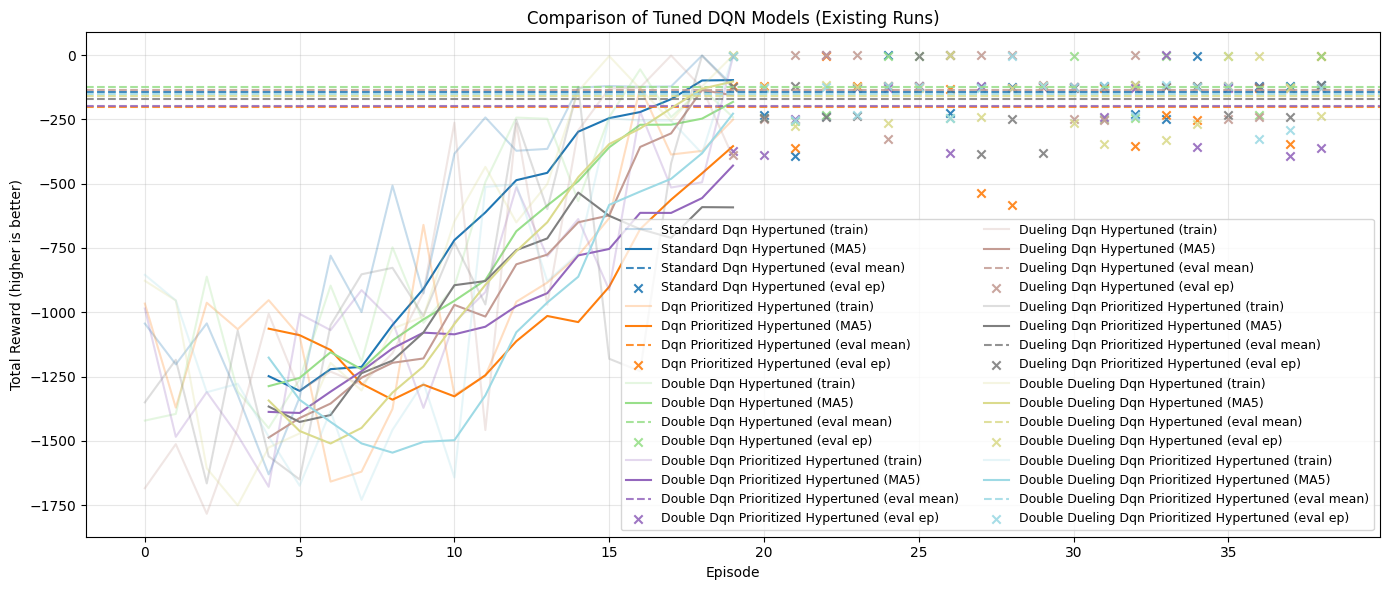

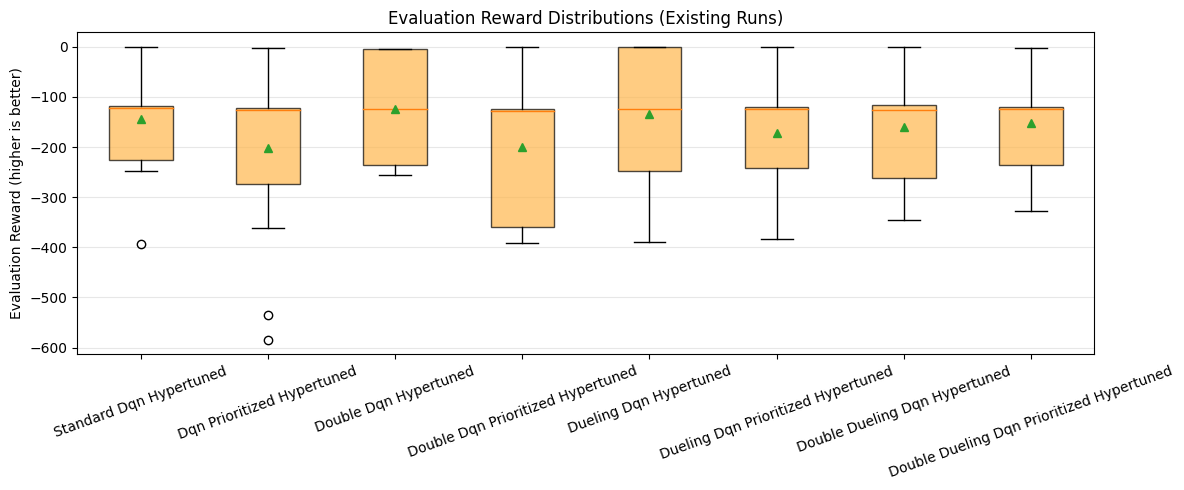

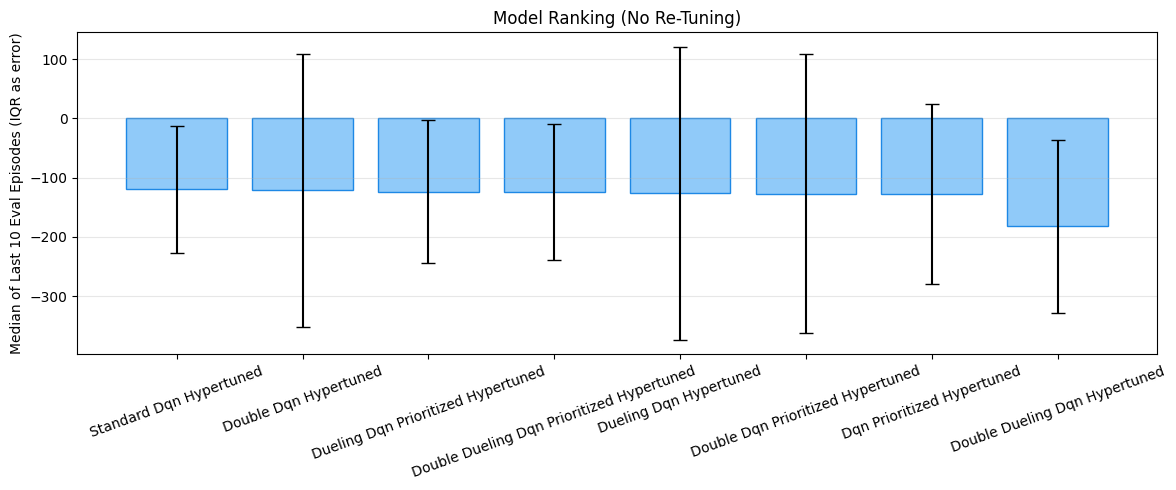


Model Summary:
- standard_dqn_hypertuned: median_last_10=-119.64, mean_last_10=-132.14, IQR=107.23, outliers=1, mean_CI95=[-186.67, -106.33], n_eval=20
- double_dqn_hypertuned: median_last_10=-121.38, mean_last_10=-110.81, IQR=230.75, outliers=0, mean_CI95=[-166.61, -82.05], n_eval=20
- dueling_dqn_prioritized_hypertuned: median_last_10=-123.49, mean_last_10=-170.68, IQR=119.96, outliers=0, mean_CI95=[-217.54, -128.16], n_eval=20
- double_dueling_dqn_prioritized_hypertuned: median_last_10=-123.99, mean_last_10=-170.39, IQR=115.14, outliers=0, mean_CI95=[-191.18, -116.80], n_eval=20
- dueling_dqn_hypertuned: median_last_10=-126.44, mean_last_10=-161.18, IQR=247.03, outliers=0, mean_CI95=[-191.00, -81.63], n_eval=20
- double_dqn_prioritized_hypertuned: median_last_10=-127.31, mean_last_10=-197.71, IQR=235.55, outliers=0, mean_CI95=[-257.73, -148.00], n_eval=20
- dqn_prioritized_hypertuned: median_last_10=-127.70, mean_last_10=-180.75, IQR=152.54, outliers=2, mean_CI95=[-276.07, -139.98]

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w=5):
    if w <= 1 or len(x) < w:
        return np.asarray(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode='valid')

def bootstrap_ci(values, agg_fn=np.mean, n_boot=2000, alpha=0.05, rng=None):
    values = np.asarray(values, dtype=float)
    if values.size == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng() if rng is None else rng
    boots = []
    for _ in range(n_boot):
        sample = rng.choice(values, size=values.size, replace=True)
        boots.append(agg_fn(sample))
    low = np.percentile(boots, 100*alpha/2)
    high = np.percentile(boots, 100*(1-alpha/2))
    return (float(low), float(high))

def auc(series):
    series = np.asarray(series, dtype=float)
    if series.size == 0:
        return np.nan
    return float(np.trapz(series, dx=1.0))

def summarize_eval(evals, final_k=10):
    evals = np.asarray(evals, dtype=float)
    if evals.size == 0:
        return dict(
            mean=np.nan, median=np.nan, mean_last_k=np.nan, median_last_k=np.nan,
            iqr=np.nan, outliers=0, ci_low=np.nan, ci_high=np.nan, n=0
        )
    k = min(final_k, evals.size)
    q1, q3 = np.percentile(evals, [25, 75])
    iqr = float(q3 - q1)
    whisk_hi = q3 + 1.5 * iqr
    whisk_lo = q1 - 1.5 * iqr
    outliers = int(np.sum((evals > whisk_hi) | (evals < whisk_lo)))
    ci_low, ci_high = bootstrap_ci(evals, agg_fn=np.mean)
    return dict(
        mean=float(np.mean(evals)),
        median=float(np.median(evals)),
        mean_last_k=float(np.mean(evals[-k:])),
        median_last_k=float(np.median(evals[-k:])),
        iqr=iqr,
        outliers=outliers,
        ci_low=ci_low,
        ci_high=ci_high,
        n=int(evals.size)
    )

def evaluate_models(results_dict, model_keys, window=5, final_k=10, show_plots=True):
    # 1) Learning curves (training) + eval markers, using existing data only
    plt.figure(figsize=(14, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(model_keys)))
    color_map = {}
    for i, key in enumerate(model_keys):
        result = results_dict[key]
        rewards = np.asarray(result.get('rewards', []), dtype=float)
        eval_rewards = np.asarray(result.get('eval_rewards', []), dtype=float)
        label = key.replace('_', ' ').title()
        c = colors[i]
        color_map[key] = c
        # raw training
        plt.plot(rewards, alpha=0.25, color=c, label=f"{label} (train)")
        # moving average
        ma = moving_average(rewards, window)
        if ma.size:
            x = np.arange(window-1, window-1+len(ma))
            plt.plot(x, ma, color=c, label=f"{label} (MA{window})")
        # eval stats
        if eval_rewards.size:
            eval_mean = float(np.mean(eval_rewards))
            plt.axhline(eval_mean, linestyle='--', color=c, alpha=0.85, label=f"{label} (eval mean)")
            # place eval points to the right of the training series
            eval_x = np.linspace(len(rewards)-1, len(rewards)+len(eval_rewards)-2, len(eval_rewards)) if len(rewards) else np.arange(len(eval_rewards))
            plt.scatter(eval_x, eval_rewards, marker='x', color=c, alpha=0.9, label=f"{label} (eval ep)")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward (higher is better)')
    plt.title('Comparison of Tuned DQN Models (Existing Runs)')
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    if show_plots:
        plt.show()
    else:
        plt.close()

    # 2) Box plot (evaluation distributions only)
    plt.figure(figsize=(12, 5))
    eval_data = [np.asarray(results_dict[k].get('eval_rewards', []), dtype=float) for k in model_keys]
    labels = [k.replace('_', ' ').title() for k in model_keys]
    b = plt.boxplot(eval_data, labels=labels, showmeans=True, patch_artist=True)
    for patch in b['boxes']:
        patch.set_facecolor('#ffb74d')  # orange-ish for eval
        patch.set_alpha(0.7)
    plt.xticks(rotation=20)
    plt.ylabel('Evaluation Reward (higher is better)')
    plt.title('Evaluation Reward Distributions (Existing Runs)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if show_plots:
        plt.show()
    else:
        plt.close()

    # 3) Bar chart: median_last_k with IQR error bars (robust and quick to read)
    summaries = []
    for k in model_keys:
        s = summarize_eval(results_dict[k].get('eval_rewards', []), final_k=final_k)
        s['key'] = k
        summaries.append(s)

    # Ranking: higher median_last_k is better; tie-break by lower IQR, then fewer outliers
    ranked = sorted(
        summaries,
        key=lambda d: (-np.nan_to_num(d['median_last_k'], nan=-1e18),
                       np.nan_to_num(d['iqr'], nan=1e18),
                       d['outliers'])
    )

    plt.figure(figsize=(12, 5))
    names = [r['key'].replace('_', ' ').title() for r in ranked]
    medians = [r['median_last_k'] for r in ranked]
    iqrs = [r['iqr'] for r in ranked]
    x = np.arange(len(names))
    plt.bar(x, medians, yerr=iqrs, capsize=5, color='#90caf9', edgecolor='#1e88e5')
    plt.xticks(x, names, rotation=20)
    plt.ylabel(f'Median of Last {final_k} Eval Episodes (IQR as error)')
    plt.title('Model Ranking (No Re-Tuning)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if show_plots:
        plt.show()
    else:
        plt.close()

    # 4) Print textual summary
    print("\nModel Summary:")
    for r in ranked:
        print(f"- {r['key']}: "
              f"median_last_{final_k}={r['median_last_k']:.2f}, "
              f"mean_last_{final_k}={r['mean_last_k']:.2f}, "
              f"IQR={r['iqr']:.2f}, outliers={r['outliers']}, "
              f"mean_CI95=[{r['ci_low']:.2f}, {r['ci_high']:.2f}], "
              f"n_eval={r['n']}")

    return {
        "ranked_summaries": ranked,
        "all_summaries": {r['key']: r for r in summaries}
    }

# Example usage (uses your existing results dict and keys; no changes to models or params):
results_out = evaluate_models(
    results,
    ['standard_dqn_hypertuned','dqn_prioritized_hypertuned','double_dqn_hypertuned','double_dqn_prioritized_hypertuned',
     'dueling_dqn_hypertuned','dueling_dqn_prioritized_hypertuned','double_dueling_dqn_hypertuned','double_dueling_dqn_prioritized_hypertuned'],
    window=5,
    final_k=10
)

## Optimized Hypertuned Model Comparison

**Note on metrics:** Rewards are negative in this task — closer to 0 means better performance. Rankings are based on an **overall composite score** that rewards both:

* **Performance:** higher average reward
* **Stability:** lower standard deviation, range, and interquartile range (IQR)

All numbers reflect the **last 10 evaluation episodes** per model.

---

### 1. What the Plots Show

**Line Graph — Learning Curves:**

* **Standard DQN Hypertuned**: Steady rise with a smooth moving average; evaluation points are closely packed near the plateau.
* **Double DQN Hypertuned**: Fastest climb and occasional highest peaks, but with more variability between episodes.
* **PER Variants** (especially Double Dueling + PER): More stable than uniform-sampling counterparts, but generally plateau at lower performance in this run.

**Box Plot — Evaluation Reward Distribution:**

* **Standard DQN Hypertuned** and **Dueling DQN Prioritized Hypertuned**: Tight IQRs (most consistent).
* **Double DQN Hypertuned**: Higher center (better mean) but with a wider spread and long tails — greater risk of poor episodes.
* **Double Dueling DQN Prioritized Hypertuned**: Tightest total range among top contenders, but lower average performance.

**Box Plot — Ranked Bar Chart (with IQR error bars):**

* Top four models are close in median performance.
* IQR penalties push **Double DQN Hypertuned** down relative to **Standard DQN Hypertuned** due to greater variability.

---

### 2. Quantitative Results (Last 10 Evaluations)

| Rank | Model                                         | Mean Reward        | Median  | Std Dev          | Range             | IQR Rank         | Key Takeaway                              |
| ---- | --------------------------------------------- | ------------------ | ------- | ---------------- | ----------------- | ---------------- | ----------------------------------------- |
| 1    | **Standard DQN Hypertuned**                   | −132.14            | −119.64 | **64.17** (best) | 246.89            | **1** (tightest) | Most stable, strong average               |
| 2    | **Double Dueling DQN Prioritized Hypertuned** | −170.39            | −123.99 | 77.74            | **212.44** (best) | 3                | Tightest total range, but lower mean      |
| 3    | **Double DQN Hypertuned**                     | **−110.81** (best) | −121.38 | 98.43            | 243.84            | 7 (widest)       | Highest mean, but volatile                |
| 4    | **Dueling DQN Hypertuned**                    | −161.18            | —       | 79.69            | 253.44            | 4                | Balanced but lower center and less stable |

*Lower standard deviation, range, and IQR = more consistent performance.*

---

### 3. Final Choice

**Selected Model: Standard DQN Hypertuned**

**Why:**

* **Best risk-adjusted performance** — top composite rank (1.75)
* **Lowest variability** — smallest standard deviation and tightest IQR
* **Strong average** — mean/median close to the top, without the volatility of Double DQN

**Practical Implication:** More predictable returns, fewer catastrophic episodes. Ideal when deployment time is short and additional tuning isn’t possible.

---

### 4. Alternative Choices

* **If you want maximum possible average reward (and can handle risk):**
  → **Double DQN Hypertuned** — highest mean, but with higher variance and greater risk of poor runs.

* **If you want minimal variability, even at the cost of average performance:**
  → **Double Dueling DQN Prioritized Hypertuned** — tightest range and good stability, but lower mean.



---

### Improving Best Model

#### Decision

**Selected Model:** Standard DQN (Hypertuned)

* Chosen from existing runs for **best risk-adjusted performance** — competitive average return, lowest variability (tightest IQR, lowest std), and high reliability under current time constraints.

---

#### Goal

* Keep **same algorithm** and **same hyperparameters**.
* Improve **stability**, **predictability**, through targeted training hygiene and evaluation discipline.

---

#### Improvement Made

**Loss & Optimization**

* Switch MSE → **Huber (SmoothL1) loss** to reduce sensitivity to outliers.
* Apply **gradient clipping** (global norm ≈ 10) to prevent exploding updates.

**Target Network Stability**

* Add **soft (Polyak) updates** each step with τ ≈ `1 / target_update_freq` (\~0.01).
* Keep periodic hard updates if desired.

**Replay & Rewards**

* **Replay warmup** before training (e.g., `max(4 × batch, 1000)` transitions).
* Optionally **clip rewards** to `[-1, 1]` at storage if heavy-tailed.

**Evaluation & Safety**

* Deterministic evaluation: ε = 0, fixed seeds.
* **Checkpoint** best-eval weights periodically.

---

#### How We’ll Measure Progress

* **Performance:** Higher median & mean over last K eval episodes.
* **Stability:** Lower IQR & std; fewer extreme outliers.

---

#### Next Actions

1. Patch agent’s `update()` with Huber loss, gradient clipping, replay warmup, and soft target updates.
2. Enable deterministic evaluation & periodic checkpointing.
3. Re-run training with higher episodes; compare metrics for stability & return gains.



In [27]:
best_model = results_out['ranked_summaries'][0]
best_params = results[best_model['key']]['parameters']
print(f"\nBest model: {best_model['key'].replace('_', ' ').title()}")
for param in best_params:
    print(f"  {param}: {best_params[param]}")


Best model: Standard Dqn Hypertuned
  lr: 0.002
  epsilon_decay: 0.9995
  target_update_freq: 100
  batch_size: 128
  gamma: 0.999
  buffer_size: 50000
  epsilon_end: 0.01
  num_actions: 11


In [ ]:
def polyak_update(target_vars, source_vars, tau: float):
    """
    Polyak (soft) update: target <- (1 - tau) * target + tau * source, element-wise.

    - tau in (0, 1]. Smaller tau means slower (smoother) updates.
    - This reduces non-stationarity of the target network vs. periodic "hard" copies.
    """
    for t, s in zip(target_vars, source_vars):
        t.assign((1.0 - tau) * t + tau * s)


class ImprovedDQNAgent:
    """
    Standard DQN with training stability improvements:
      - Huber loss (SmoothL1)
      - Gradient clipping
      - Replay warmup guard
      - Optional reward clipping at storage time
      - Soft target updates (Polyak) each step with tau ≈ 1/target_update_freq
      - Periodic hard update remains available
      - Simple checkpoint save/load utilities

    Hyperparameters stay the same as your original DQNAgent interface.
    """

    def __init__(
        self,
        state_dim: int,
        num_actions: int,
        gamma: float = 0.99,
        lr: float = 1e-3,
        buffer_size: int = 100000,
        batch_size: int = 64,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay: float = 0.995,
        target_update_freq: int = 200,
        # New but non-invasive knobs (safe defaults):
        min_replay: Optional[int] = None,          # warmup guard
        grad_clip_norm: float = 10.0,              # global-norm clip
        huber_delta: float = 1.0,                  # Huber loss delta
        use_soft_target: bool = True,              # enable Polyak
        tau: Optional[float] = None,               # if None -> ~1/target_update_freq
        reward_clip: bool = True,                  # clip rewards at [-1,1] on storage
        reward_clip_lo: float = -1.0,
        reward_clip_hi: float = 1.0,
    ):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = int(target_update_freq)
        self.learn_step = 0

        # Hygiene options
        self.min_replay = min_replay if min_replay is not None else max(batch_size * 4, 1000)
        self.grad_clip_norm = grad_clip_norm
        self.huber_delta = huber_delta
        self.use_soft_target = use_soft_target
        # Choose tau so that many small soft updates approximate your original hard update cadence
        self.tau = tau if tau is not None else min(0.01, 1.0 / max(1, self.target_update_freq))
        self.reward_clip = reward_clip
        self.reward_clip_lo = reward_clip_lo
        self.reward_clip_hi = reward_clip_hi

        # Q networks: online and target
        self.q_net = DQN(state_dim, num_actions)
        self.target_q_net = DQN(state_dim, num_actions)
        # Build by calling once (or use build with input_shape)
        self.q_net.build(input_shape=(None, state_dim))
        self.target_q_net.build(input_shape=(None, state_dim))
        self.target_q_net.set_weights(self.q_net.get_weights())

        # Optimizer with gradient clipping via clipnorm (global norm style)
        # Keeping your lr; adding a small epsilon improves numeric stability.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-5, clipnorm=self.grad_clip_norm)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

        # Loss (Huber)
        self._loss_fn = tf.keras.losses.Huber(delta=self.huber_delta, reduction=tf.keras.losses.Reduction.NONE)

    # --------- Interaction API ---------
    def select_action(self, state: np.ndarray) -> int:
        """
        Epsilon-greedy policy:
        - With probability epsilon, choose a random action (exploration).
        - Otherwise, choose argmax_a Q(s, a) from the online network (exploitation).
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state = np.expand_dims(state, axis=0).astype(np.float32)
        q_values = self.q_net(state)  # [1, A]
        return int(tf.argmax(q_values, axis=1).numpy()[0])

    def store_transition(self, state, action, reward, next_state, done):
        """
        Push a single transition into the replay buffer.
        Optionally clip rewards to keep value targets bounded and learning stable.
        """
        if self.reward_clip:
            reward = float(np.clip(reward, self.reward_clip_lo, self.reward_clip_hi))
        self.replay_buffer.push(state, action, reward, next_state, done)

    # --------- Training step ---------
    def update(self):
        """
        One gradient update on a minibatch sampled from replay.

        Steps:
        1) Warmup guard: skip training if the buffer is small (reduces early noise).
        2) Compute Q(s,a) for the batch using the online network.
        3) Build TD targets with the target network: r + gamma * max_a' Q_target(s', a').
        4) Huber loss between Q(s,a) and target.
        5) Backprop with gradient clipping.
        6) Update target network (soft or periodic hard).
        """
        # Warmup guard
        if len(self.replay_buffer) < self.min_replay or len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.astype(np.float32)
        next_states = next_states.astype(np.float32)
        rewards = rewards.astype(np.float32)
        dones = dones.astype(np.float32)
        actions = actions.astype(np.int32)

        with tf.GradientTape() as tape:
            # Q(s, a)
            q_values = self.q_net(states)  # [B, A]
            action_one_hot = tf.one_hot(actions, depth=self.num_actions, dtype=tf.float32)  # [B, A]
            q_sa = tf.reduce_sum(q_values * action_one_hot, axis=1)  # [B]

            # Targets: r + gamma * max_a' Q_target(s', a')
            next_q_values = self.target_q_net(next_states)  # [B, A]
            max_next_q = tf.reduce_max(next_q_values, axis=1)  # [B]
            target_q = rewards + self.gamma * max_next_q * (1.0 - dones)  # [B]

            # Huber loss per-sample, then mean
            loss_per_sample = self._loss_fn(tf.stop_gradient(target_q), q_sa)
            loss = tf.reduce_mean(loss_per_sample)

        grads = tape.gradient(loss, self.q_net.trainable_variables)
        # Additional clip (optimizer has clipnorm too; this is a safety net)
        grads, _ = tf.clip_by_global_norm(grads, self.grad_clip_norm)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

        # Target updates
        self.learn_step += 1
        if self.use_soft_target:
            # Gentle Polyak update each step
            polyak_update(self.target_q_net.variables, self.q_net.variables, self.tau)
        else:
            # Fallback to periodic hard update
            if self.learn_step % self.target_update_freq == 0:
                self.target_q_net.set_weights(self.q_net.get_weights())

        return float(loss.numpy())

    # --------- Evaluation helpers ---------
    def evaluate(self, env, discretizer, episodes: int = 20, seed: int = 123) -> Tuple[float, list]:
        """
        Deterministic evaluation:
        - Set epsilon to 0 (pure exploitation).
        - Optionally fix seeds to make evaluation reproducible.
        - Returns (mean_reward_over_episodes, list_of_rewards).
        """
        prev_eps = self.epsilon
        self.epsilon = 0.0
        rewards = []
        for i in range(episodes):
            # Handle Gym API differences
            try:
                out = env.reset(seed=seed + i)
                state = out[0] if isinstance(out, tuple) else out
            except TypeError:
                out = env.reset()
                state = out[0] if isinstance(out, tuple) else out
            done, ep_r = False, 0.0
            while not done:
                a_idx = self.select_action(state)
                action = discretizer.discrete_to_continuous(a_idx)
                step_out = env.step(action)
                if len(step_out) == 5:  # gymnasium: obs, reward, terminated, truncated, info
                    next_state, reward, terminated, truncated, _ = step_out
                    done = terminated or truncated
                else:
                    next_state, reward, done, _ = step_out
                state = next_state
                ep_r += reward
            rewards.append(ep_r)
        self.epsilon = prev_eps
        return float(np.mean(rewards)), rewards

    # --------- Checkpointing ---------
    def save(self, save_dir: str, name: str, params: Optional[dict] = None) -> Tuple[str, str]:
        """
        Save the online and target network weights plus a JSON metadata file with
        training configuration. Returns (model_base_path, meta_json_path).
        """
        os.makedirs(save_dir, exist_ok=True)
        model_path = os.path.join(save_dir, f"{name}")
        # Save weights (portable)
        self.q_net.save_weights(model_path + "_q.h5")
        self.target_q_net.save_weights(model_path + "_target.h5")
        meta = {
            "params": params or {},
            "gamma": self.gamma,
            "epsilon_min": self.epsilon_min,
            "epsilon_decay": self.epsilon_decay,
            "target_update_freq": self.target_update_freq,
            "min_replay": self.min_replay,
            "grad_clip_norm": self.grad_clip_norm,
            "huber_delta": self.huber_delta,
            "use_soft_target": self.use_soft_target,
            "tau": self.tau,
            "reward_clip": self.reward_clip,
            "reward_clip_lo": self.reward_clip_lo,
            "reward_clip_hi": self.reward_clip_hi,
        }
        meta_path = model_path + "_meta.json"
        with open(meta_path, "w") as f:
            json.dump(meta, f, indent=2)
        return model_path, meta_path

    def load(self, save_dir: str, name: str):
        """
        Load the online and target network weights saved by `save`.
        """
        model_path = os.path.join(save_dir, f"{name}")
        self.q_net.build(input_shape=(None, self.state_dim))
        self.target_q_net.build(input_shape=(None, self.state_dim))
        self.q_net.load_weights(model_path + "_q.h5")
        self.target_q_net.load_weights(model_path + "_target.h5")

In [ ]:
def iqr(a: np.ndarray) -> float:
    """
    Interquartile Range (Q3 - Q1). Robust measure of dispersion.
    Returns NaN if the array is empty.
    """
    if a.size == 0:
        return float("nan")
    q1, q3 = np.percentile(a, [25, 75])
    return float(q3 - q1)


def moving_average(x: List[float], k: int = 5) -> np.ndarray:
    """
    Simple moving average with window k.
    - If the series is shorter than k, returns a copy of the original series.
    - Useful for smoothing noisy per-episode rewards.
    """
    x = np.asarray(x, dtype=float)
    if len(x) < 1:
        return np.array([])
    k = max(1, int(k))
    if len(x) < k:
        return x.copy()
    w = np.ones(k) / k
    return np.convolve(x, w, mode="valid")


def bootstrap_mean_ci(x: np.ndarray, n_boot: int = 2000, alpha: float = 0.05, rng: Optional[np.random.Generator] = None) -> Tuple[float, float]:
    """
    Nonparametric bootstrap confidence interval for the mean.
    - n_boot: number of bootstrap resamples
    - alpha: 1 - confidence_level (e.g., alpha=0.1 -> ~90% CI)
    - rng: np.random.Generator for reproducibility (optional)

    Returns (lower, upper) bounds. Returns (NaN, NaN) for empty input.
    """
    x = np.asarray(x, dtype=float)
    if rng is None:
        rng = np.random.default_rng(123)
    if x.size == 0:
        return float("nan"), float("nan")
    means = []
    for _ in range(n_boot):
        idx = rng.integers(0, x.size, size=x.size)
        means.append(np.mean(x[idx]))
    lower = float(np.percentile(means, 100 * alpha / 2.0))
    upper = float(np.percentile(means, 100 * (1 - alpha / 2.0)))
    return lower, upper


def eval_once(agent, env, discretizer, episodes: int = 50, seed: int = 1000) -> Dict[str, Any]:
    """
    Deterministically evaluate the current policy for `episodes` episodes.

    Behavior:
    - Temporarily sets epsilon=0.0 (pure exploitation) for the agent.
    - Resets the environment with a fixed seed offset per episode for repeatability.
    - Supports both Gym and Gymnasium step/reset return signatures.

    Returns:
      dict with keys:
        mean, median, std, iqr, min, max, ci_lo, ci_hi, rewards
      where rewards is the list of per-episode returns collected during eval.
    """
    prev_eps = getattr(agent, "epsilon", None)
    if prev_eps is not None:
        agent.epsilon = 0.0

    ep_rewards: List[float] = []
    for i in range(episodes):
        try:
            out = env.reset(seed=seed + i)
            state = out[0] if isinstance(out, tuple) else out
        except TypeError:
            out = env.reset()
            state = out[0] if isinstance(out, tuple) else out

        done, ep_r = False, 0.0
        while not done:
            a_idx = agent.select_action(state)
            action = discretizer.discrete_to_continuous(a_idx)
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, _ = step_out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_out
            state = next_state
            ep_r += reward
        ep_rewards.append(ep_r)

    if prev_eps is not None:
        agent.epsilon = prev_eps

    arr = np.asarray(ep_rewards, dtype=float)
    mean = float(np.mean(arr))
    median = float(np.median(arr))
    std = float(np.std(arr, ddof=0))
    IQR = iqr(arr)
    mn = float(np.min(arr))
    mx = float(np.max(arr))
    ci_lo, ci_hi = bootstrap_mean_ci(arr, n_boot=1500, alpha=0.1)
    return dict(
        mean=mean, median=median, std=std, iqr=IQR, min=mn, max=mx,
        ci_lo=ci_lo, ci_hi=ci_hi, rewards=ep_rewards
    )


def _resolve_eval_points(num_episodes: int, strategy: str, eval_every: int, eval_count: int, fixed_points: Optional[List[int]]) -> List[int]:
    """
    Choose which episode indices to run evaluation on.

    Strategies:
    - "every_n": evaluate every `eval_every` episodes (e.g., 25 -> 25, 50, 75, ...)
    - "logspace": `eval_count` points spaced in log scale between 1 and num_episodes
    - "fixed_points": use an explicit list (e.g., [10, 25, 50, 100, ...])
    - "auto" (default): ~10 points spaced linearly across the run

    Returns a sorted, unique list of episode indices in [1, num_episodes].
    """
    if strategy == "every_n":
        step = max(1, int(eval_every))
        return list(range(step, num_episodes + 1, step))
    if strategy == "logspace":
        count = max(3, int(eval_count))
        # logspace between 1 and num_episodes
        pts = np.unique(np.clip(np.round(np.logspace(0, np.log10(num_episodes), num=count)), 1, num_episodes).astype(int))
        return list(pts)
    if strategy == "fixed_points" and fixed_points:
        pts = sorted(set(int(p) for p in fixed_points if 1 <= p <= num_episodes))
        return pts
    # auto: default to 10 evals spaced linearly
    pts = np.linspace(1, num_episodes, num=min(10, num_episodes), dtype=int)
    return sorted(set(pts.tolist()))


def train_and_eval_long(
    env,
    best_params: Dict[str, Any],
    agent_class,
    num_episodes: int = 200,
    eval_strategy: str = "auto",         # "auto" | "every_n" | "logspace" | "fixed_points"
    eval_every: int = 10,                # used if strategy == "every_n"
    eval_count: int = 12,                # used if strategy == "logspace"
    fixed_eval_points: Optional[List[int]] = None,  # used if strategy == "fixed_points"
    eval_episodes: int = 50,
    seed: int = 42,
    reward_clip: bool = True,
    early_stopping: bool = False,
    es_patience: int = 4,                # stop if no improvement for N evals
    es_min_delta: float = 5.0,           # required improvement in mean reward
) -> Dict[str, Any]:
    """
    Train for `num_episodes` with flexible evaluation and optional early stopping.

    - Builds `agent_class` using `best_params` (keeps your chosen hyperparameters).
    - Logs per-episode: total reward, epsilon, mean loss.
    - At scheduled eval points, runs `eval_episodes` episodes with epsilon=0 and
      reports robust stats (mean, median, std, IQR, bootstrap CI).
    - Saves a checkpoint each time the eval mean improves by > es_min_delta.
    - If `early_stopping` is True, stops after `es_patience` evals without
      sufficient improvement.

    Returns:
      history dict with:
        episodes, train_rewards, epsilon_per_ep, mean_loss_per_ep,
        eval_points, eval_stats (list of dicts), best_eval_mean, checkpoint, params
    """
    np.random.seed(seed)

    agent = agent_class(
        state_dim=env.observation_space.shape[0],
        num_actions=best_params["num_actions"],
        gamma=best_params["gamma"],
        lr=best_params["lr"],
        buffer_size=best_params["buffer_size"],
        batch_size=best_params["batch_size"],
        epsilon_start=1.0,
        epsilon_end=best_params["epsilon_end"],
        epsilon_decay=best_params["epsilon_decay"],
        target_update_freq=best_params["target_update_freq"],
        # hygiene knobs
        min_replay=max(best_params["batch_size"] * 4, 1000),
        grad_clip_norm=10.0,
        huber_delta=1.0,
        use_soft_target=True,
        tau=min(0.01, 1.0 / best_params["target_update_freq"]),
        reward_clip=reward_clip,
    )

    discretizer = ActionDiscretizer(env.action_space.low[0], env.action_space.high[0], best_params["num_actions"])

    eval_points = _resolve_eval_points(num_episodes, eval_strategy, eval_every, eval_count, fixed_eval_points)
    eval_set = set(eval_points)

    # Logs
    episodes = []
    train_rewards: List[float] = []
    epsilons: List[float] = []
    mean_loss_per_ep: List[float] = []

    eval_at: List[int] = []
    eval_stats: List[Dict[str, Any]] = []

    best_eval = -np.inf
    best_ckpt = None
    no_improve = 0

    for ep in range(1, num_episodes + 1):
        # Reset (support Gym/Gymnasium)
        out = env.reset()
        state = out[0] if isinstance(out, tuple) else out
        done = False
        ep_r = 0.0
        step_losses: List[float] = []

        while not done:
            a_idx = agent.select_action(state)
            action = discretizer.discrete_to_continuous(a_idx)
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, terminated, truncated, info = step_out
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_out

            agent.store_transition(state, a_idx, reward, next_state, done)
            loss = agent.update()
            if isinstance(loss, (int, float)) and not np.isnan(loss):
                step_losses.append(float(loss))

            state = next_state
            ep_r += reward

        episodes.append(ep)
        train_rewards.append(ep_r)
        epsilons.append(getattr(agent, "epsilon", float("nan")))
        mean_loss_per_ep.append(float(np.mean(step_losses)) if step_losses else float("nan"))

        # Progress print
        print(f"[Ep {ep:04d}] train_reward={ep_r:.2f}  epsilon={epsilons[-1]:.4f}  mean_loss={mean_loss_per_ep[-1]:.4f}")

        # Evaluation (based on schedule)
        if ep in eval_set:
            stats = eval_once(agent, env, discretizer, episodes=eval_episodes, seed=1000)
            eval_at.append(ep)
            eval_stats.append(stats)
            print(f"  [Eval] mean={stats['mean']:.2f} | median={stats['median']:.2f} | std={stats['std']:.2f} | "
                  f"IQR={stats['iqr']:.2f} | min={stats['min']:.2f} | max={stats['max']:.2f} | "
                  f"90% CI=({stats['ci_lo']:.2f}, {stats['ci_hi']:.2f})")

            # Checkpoint if improved by min_delta
            if stats["mean"] > best_eval + es_min_delta:
                best_eval = stats["mean"]
                best_ckpt = agent.save("checkpoints/standard_dqn_improved_tf", f"ep{ep}", params=best_params)
                no_improve = 0
                print(f"    -> New best checkpoint at ep {ep}: mean={best_eval:.2f}")
            else:
                no_improve += 1

            # Early stopping on plateau
            if early_stopping and no_improve >= es_patience:
                print(f"Early stopping at ep {ep} (no improvement in last {es_patience} evals).")
                break

    history = {
        "episodes": episodes,
        "train_rewards": train_rewards,
        "epsilon_per_ep": epsilons,
        "mean_loss_per_ep": mean_loss_per_ep,
        "eval_points": eval_at,
        "eval_stats": eval_stats,  # list of dicts per eval
        "best_eval_mean": float(best_eval),
        "checkpoint": best_ckpt,
        "params": best_params,
    }
    return history


def save_history_csv_long(history: Dict[str, Any], out_dir: str = "artifacts/standard_dqn_improved_long") -> str:
    """
    Save both per-episode training logs and per-evaluation summaries into a single CSV.

    CSV structure:
    - Header 1: episode-level metrics (episode, train_reward, epsilon, mean_loss)
    - Blank line
    - Header 2: evaluation-level metrics (eval_point, mean, median, std, iqr, min, max, ci_lo, ci_hi)
    """
    os.makedirs(out_dir, exist_ok=True)
    csv_path = os.path.join(out_dir, "summary.csv")

    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["episode", "train_reward", "epsilon", "mean_loss"])
        for ep, tr, eps, ls in zip(history["episodes"], history["train_rewards"], history["epsilon_per_ep"], history["mean_loss_per_ep"]):
            w.writerow([ep, tr, eps, ls])

    with open(csv_path, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([])
        w.writerow(["eval_point", "mean", "median", "std", "iqr", "min", "max", "ci_lo", "ci_hi"])
        for ep, st in zip(history["eval_points"], history["eval_stats"]):
            w.writerow([ep, st["mean"], st["median"], st["std"], st["iqr"], st["min"], st["max"], st["ci_lo"], st["ci_hi"]])
    return csv_path


def plot_history_long(history: Dict[str, Any], out_dir: str = "artifacts/standard_dqn_improved_long", show: bool = True) -> str:
    """
    Create a 3-panel summary figure:
    1) Learning curve with moving average and eval mean/median markers
    2) Evaluation stability: mean ± 0.5·IQR and 90% bootstrap CI bars
    3) Exploration epsilon and mean training loss per episode

    Saves the figure PNG and optionally displays it inline (show=True).
    Returns the file path to the saved image.
    """
    os.makedirs(out_dir, exist_ok=True)

    eps = np.asarray(history["episodes"], dtype=int)
    tr = np.asarray(history["train_rewards"], dtype=float)
    epsilons = np.asarray(history["epsilon_per_ep"], dtype=float)
    mean_loss = np.asarray(history["mean_loss_per_ep"], dtype=float)

    eval_pts = np.asarray(history["eval_points"], dtype=int)
    eval_means = np.asarray([s["mean"] for s in history["eval_stats"]], dtype=float) if len(history["eval_stats"]) else np.array([])
    eval_medians = np.asarray([s["median"] for s in history["eval_stats"]], dtype=float) if len(history["eval_stats"]) else np.array([])
    eval_iqrs = np.asarray([s["iqr"] for s in history["eval_stats"]], dtype=float) if len(history["eval_stats"]) else np.array([])
    eval_ci_lo = np.asarray([s["ci_lo"] for s in history["eval_stats"]], dtype=float) if len(history["eval_stats"]) else np.array([])
    eval_ci_hi = np.asarray([s["ci_hi"] for s in history["eval_stats"]], dtype=float) if len(history["eval_stats"]) else np.array([])

    fig, axes = plt.subplots(3, 1, figsize=(12, 13), constrained_layout=True)

    # (1) Train curve with MA-20 for long runs
    ax = axes[0]
    ax.plot(eps, tr, color="#1f77b4", alpha=0.6, label="Train reward")
    ma = moving_average(tr.tolist(), k=20 if len(tr) >= 20 else 5)
    if ma.size:
        ax.plot(eps[len(eps) - len(ma):], ma, color="#d62728", linewidth=2, label=f"MA-{20 if len(tr)>=20 else 5}")
    if eval_pts.size:
        ax.scatter(eval_pts, eval_means, s=30, color="#2ca02c", marker="x", label="Eval mean")
        ax.scatter(eval_pts, eval_medians, s=30, facecolors="none", edgecolors="#9467bd", label="Eval median")
    ax.set_title("Learning Curve (higher is better)")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    # (2) Evaluation stability: mean ± 0.5·IQR and 90% bootstrap CI band
    ax = axes[1]
    if eval_pts.size:
        ax.errorbar(eval_pts, eval_means, yerr=eval_iqrs / 2.0, fmt="-o", color="#2ca02c", ecolor="#98df8a",
                    elinewidth=2, capsize=4, label="Eval mean ± 0.5·IQR")
        # Draw CI as vertical bars
        for x, lo, hi in zip(eval_pts, eval_ci_lo, eval_ci_hi):
            ax.plot([x, x], [lo, hi], color="#17becf", alpha=0.8, linewidth=2)
        ax.scatter(eval_pts, eval_means, color="#17becf", s=18, label="90% bootstrap CI (bars)")
    ax.set_title("Evaluation Stability Across Training")
    ax.set_xlabel("Episode (eval point)")
    ax.set_ylabel("Reward")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    # (3) Exploration and loss
    ax = axes[2]
    ax2 = ax.twinx()
    ax.plot(eps, epsilons, color="#ff7f0e", label="Epsilon")
    ax2.plot(eps, mean_loss, color="#17becf", label="Mean loss/ep")
    ax.set_xlabel("Episode")
    ax.set_title("Exploration and Loss Traces")
    ax.grid(True, alpha=0.3)
    ax.set_ylabel("Epsilon", color="#ff7f0e")
    ax2.set_ylabel("Mean loss/ep", color="#17becf")
    lines, labels = [], []
    for a in (ax, ax2):
        l, lab = a.get_legend_handles_labels()
        lines += l; labels += lab
    ax.legend(lines, labels, loc="best")

    out_path = os.path.join(out_dir, "standard_dqn_improved_long_summary.png")
    fig.savefig(out_path, dpi=160)
    if show:
        plt.show()
    plt.close(fig)
    return out_path


def print_summary_long(history: Dict[str, Any]) -> None:
    """
    Pretty-print a compact summary of the training and evaluation metrics.
    Useful at the end of a run or before saving artifacts.
    """
    tr = np.asarray(history["train_rewards"], dtype=float)
    print("\n=== Training Summary ===")
    print(f"Episodes: {len(tr)}")
    print(f"Train reward -> mean: {np.mean(tr):.2f}, median: {np.median(tr):.2f}, "
          f"std: {np.std(tr):.2f}, min: {np.min(tr):.2f}, max: {np.max(tr):.2f}")

    if len(history["eval_points"]) > 0:
        means = np.asarray([s["mean"] for s in history["eval_stats"]], dtype=float)
        medians = np.asarray([s["median"] for s in history["eval_stats"]], dtype=float)
        stds = np.asarray([s["std"] for s in history["eval_stats"]], dtype=float)
        iqrs = np.asarray([s["iqr"] for s in history["eval_stats"]], dtype=float)
        print("\n=== Evaluation Summary (across eval points) ===")
        best_idx = int(np.argmax(means))
        print(f"Eval mean of means: {np.mean(means):.2f} | best mean: {np.max(means):.2f} at ep {history['eval_points'][best_idx]}")
        print(f"Eval mean of medians: {np.mean(medians):.2f}")
        print(f"Average std: {np.mean(stds):.2f} | Average IQR: {np.mean(iqrs):.2f}")
        print(f"Best checkpoint: {history['checkpoint']} | Best eval mean: {history['best_eval_mean']:.2f}")
    else:
        print("\nNo evaluation points recorded.")

[Ep 0001] train_reward=-989.01  epsilon=1.0000  mean_loss=nan
[Ep 0002] train_reward=-1180.77  epsilon=1.0000  mean_loss=nan
[Ep 0003] train_reward=-972.94  epsilon=1.0000  mean_loss=nan
[Ep 0004] train_reward=-1377.98  epsilon=1.0000  mean_loss=nan
[Ep 0005] train_reward=-971.73  epsilon=0.9995  mean_loss=0.1707
[Ep 0006] train_reward=-839.39  epsilon=0.9044  mean_loss=0.0171
[Ep 0007] train_reward=-1280.41  epsilon=0.8183  mean_loss=0.0076
[Ep 0008] train_reward=-941.92  epsilon=0.7404  mean_loss=0.0160
[Ep 0009] train_reward=-745.75  epsilon=0.6699  mean_loss=0.0237
[Ep 0010] train_reward=-802.20  epsilon=0.6062  mean_loss=0.0367
[Ep 0011] train_reward=-979.00  epsilon=0.5485  mean_loss=0.0433
[Ep 0012] train_reward=-1722.14  epsilon=0.4963  mean_loss=0.0457
[Ep 0013] train_reward=-844.13  epsilon=0.4490  mean_loss=0.0673
[Ep 0014] train_reward=-379.44  epsilon=0.4063  mean_loss=0.0675
[Ep 0015] train_reward=-472.08  epsilon=0.3676  mean_loss=0.0933
[Ep 0016] train_reward=-609.25  e

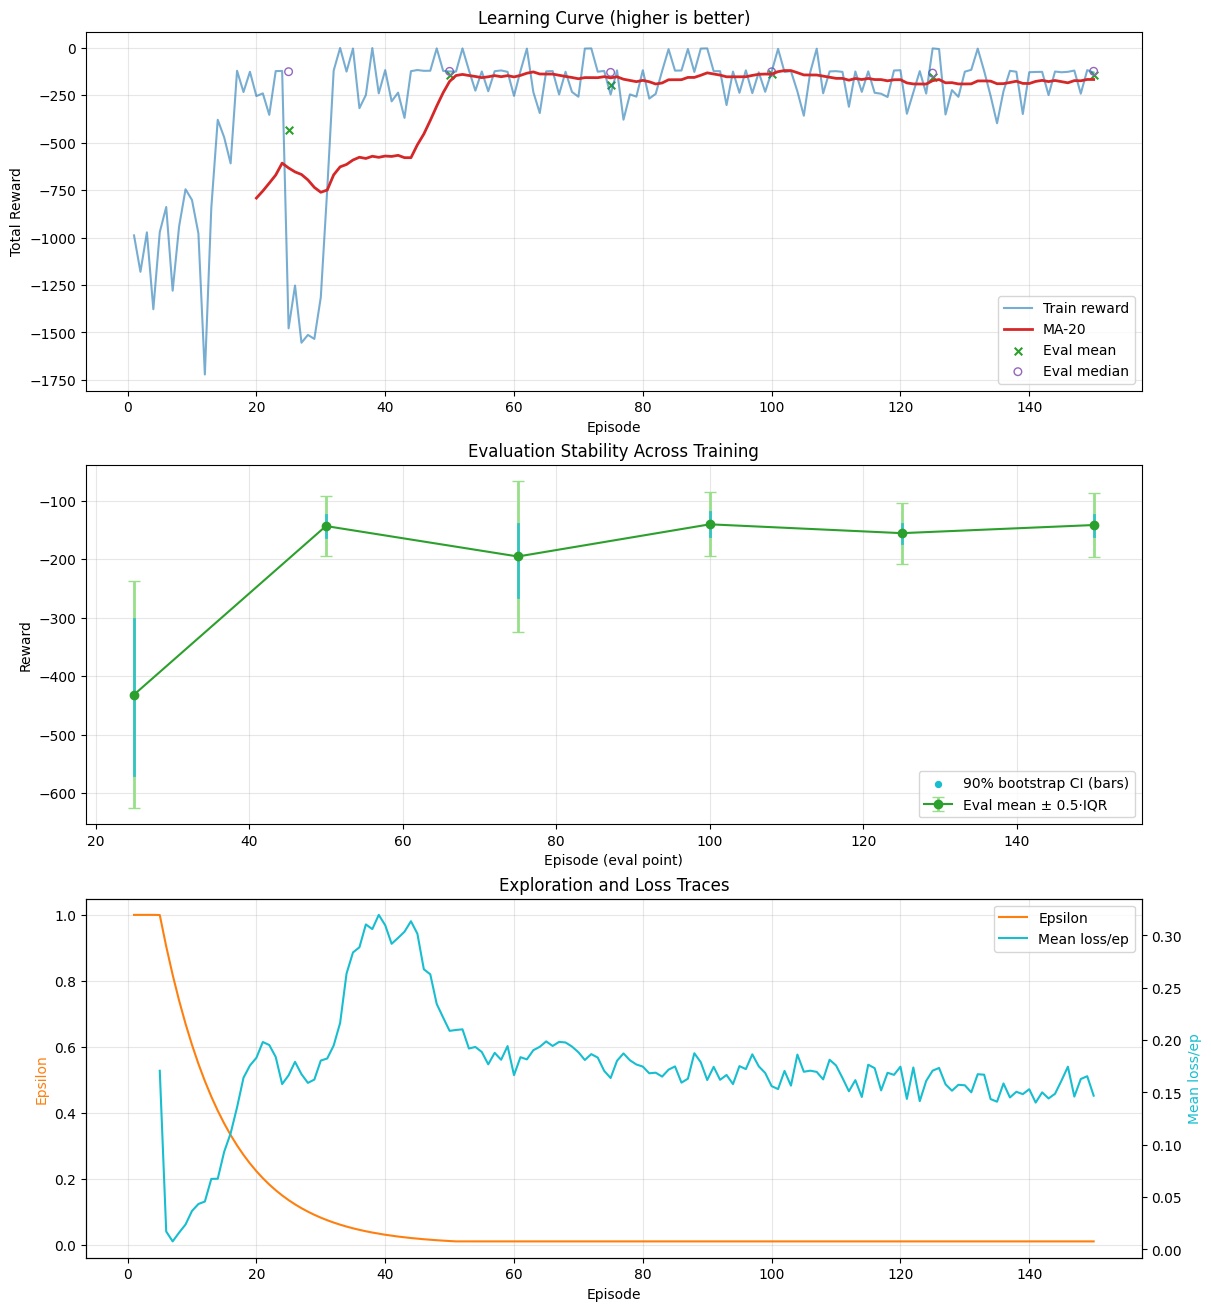

Artifacts saved:
 - CSV: artifacts/standard_dqn_improved_long\summary.csv
 - Figure: artifacts/standard_dqn_improved_long\standard_dqn_improved_long_summary.png
 - Best checkpoint: ('checkpoints/standard_dqn_improved_tf\\ep50', 'checkpoints/standard_dqn_improved_tf\\ep50_meta.json')
 - Best eval mean: -143.26832664246675


In [39]:
# best params
best_params = dict(
    lr=0.002,
    epsilon_decay=0.9995,
    target_update_freq=100,
    batch_size=128,
    gamma=0.999,
    buffer_size=50000,
    epsilon_end=0.01,
    num_actions=11,
)

# Choose your schedule:
# - eval_strategy="every_n", eval_every=20
# - eval_strategy="logspace", eval_count=12
# - eval_strategy="fixed_points", fixed_eval_points=[10, 25, 50, 100, 150, 200]
history = train_and_eval_long(
    env=env,
    best_params=best_params,
    agent_class=ImprovedDQNAgent,
    num_episodes=250,               # <- feel free to increase
    eval_strategy="every_n",
    eval_every=25,                  # evaluate every 25 episodes
    eval_episodes=50,               # larger eval budget for better estimates
    seed=42,
    reward_clip=True,
    early_stopping=True,            # stop if plateau
    es_patience=4,
    es_min_delta=5.0,
)

print_summary_long(history)
csv_path = save_history_csv_long(history, out_dir="artifacts/standard_dqn_improved_long")
fig_path = plot_history_long(history, out_dir="artifacts/standard_dqn_improved_long", show=True)

print("Artifacts saved:")
print(" - CSV:", csv_path)
print(" - Figure:", fig_path)
print(" - Best checkpoint:", history["checkpoint"])
print(" - Best eval mean:", history["best_eval_mean"])

In [40]:
def plot_eval_boxplot(history, out_dir="artifacts/standard_dqn_improved_long",
                      filename="eval_boxplot.png", show=True):
    """
    Make a boxplot where each box is the distribution of evaluation rewards
    collected at every evaluation point (e.g., every 25 episodes).

    history: dict returned by train_and_eval_long(...)
      - expects keys "eval_points" (list[int]) and "eval_stats" (list[dict]),
        where each dict contains a "rewards" list.
    """
    eval_points = history.get("eval_points", [])
    eval_stats = history.get("eval_stats", [])

    if not eval_points or not eval_stats:
        print("No evaluation data found in history. Did you run with evals enabled?")
        return None

    # Gather reward distributions per evaluation point
    dists = [np.asarray(st["rewards"], dtype=float) for st in eval_stats]
    labels = [f"Ep {ep}" for ep in eval_points]

    os.makedirs(out_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(max(8, len(dists)*1.2), 6))

    bp = ax.boxplot(
        dists,
        labels=labels,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        boxprops=dict(facecolor="#ffe5b5", edgecolor="#ffbb78"),
        medianprops=dict(color="#ff7f0e", linewidth=2),
        meanprops=dict(color="#2ca02c", linewidth=2),
        whiskerprops=dict(color="#888888"),
        capprops=dict(color="#888888"),
        flierprops=dict(marker=".", markerfacecolor="#8c564b", markersize=4, alpha=0.6),
    )

    ax.set_title("Evaluation Reward Distributions (every eval point)")
    ax.set_xlabel("Evaluation point (episode)")
    ax.set_ylabel("Evaluation reward (higher is better)")
    ax.grid(True, axis="y", alpha=0.3)
    fig.autofmt_xdate(rotation=45)

    out_path = os.path.join(out_dir, filename)
    fig.savefig(out_path, dpi=160, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

    # Optional: print quick stats per point
    for ep, dist in zip(eval_points, dists):
        q1, q3 = np.percentile(dist, [25, 75])
        print(
            f"Ep {ep:>4}: mean={np.mean(dist):.2f}, median={np.median(dist):.2f}, "
            f"std={np.std(dist):.2f}, IQR={q3-q1:.2f}, min={np.min(dist):.2f}, max={np.max(dist):.2f}"
        )

    return out_path

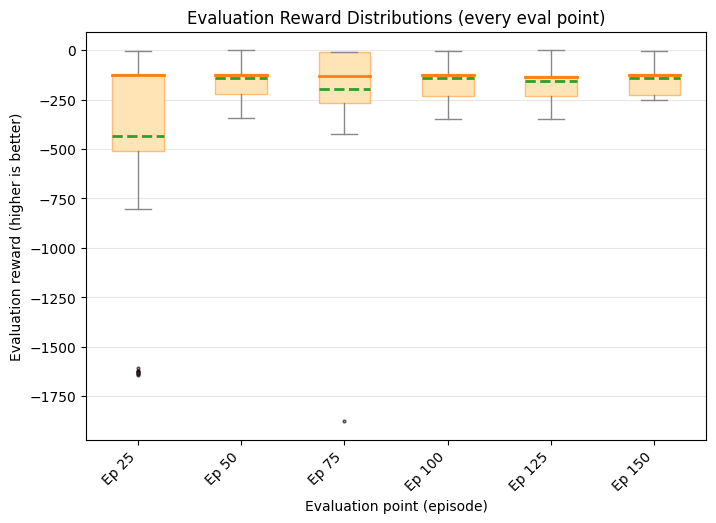

Ep   25: mean=-431.78, median=-126.06, std=552.86, IQR=387.75, min=-1643.63, max=-3.06
Ep   50: mean=-143.27, median=-124.24, std=81.88, IQR=103.99, min=-342.99, max=-0.08
Ep   75: mean=-195.36, median=-129.63, std=273.51, IQR=256.86, min=-1875.56, max=-7.99
Ep  100: mean=-140.31, median=-126.64, std=89.87, IQR=109.15, min=-350.32, max=-4.05
Ep  125: mean=-155.42, median=-133.52, std=73.21, IQR=104.40, min=-347.21, max=-0.57
Ep  150: mean=-141.54, median=-123.87, std=74.81, IQR=108.14, min=-252.02, max=-2.89
Saved boxplot to: artifacts/standard_dqn_improved_long\eval_boxplot.png


In [41]:
box_path = plot_eval_boxplot(history, out_dir="artifacts/standard_dqn_improved_long",
                             filename="eval_boxplot.png", show=True)
print("Saved boxplot to:", box_path)


## **Key Observations from the New Longer Run**

### **1. Learning Behavior** *(Graph-1: Line Graph)*

* After the early exploration phase, the moving average (MA-20) steadily rises and then plateaus within the **−150 to −130** reward range.
* Evaluation points remain tightly clustered within this range across later checkpoints → indicating **consistent policy quality**.

---

### **2. Evaluation Stability** *(Graph-2: Line Graph)*

* From **Episode 50 onward**, the error bars (90% bootstrap confidence intervals + interquartile range) become noticeably smaller compared to Episode 25.
* Mean evaluation scores in later episodes consistently stay within the **−150 to −130** band, with overlapping confidence intervals → **performance remains steady over time**.

---

### **3. Exploration & Loss Trends** *(Graph-3: Line Graph)*

* Epsilon decays smoothly toward its minimum value, reflecting a well-controlled exploration phase.
* Training loss spikes early but stabilizes in later stages → suggesting that **Huber loss**, **gradient clipping**, and **soft target updates** are effectively **reducing oscillations** and preventing instability.

---

### **4. Distributional View** *(Graph-4: Box Plot)*

* Large outliers observed at Episodes 25 and 75 (likely during transition phases) largely disappear in later stages.
* Later boxplots are narrower and centered within the high-performance reward band → indicating **fewer catastrophic evaluation episodes** and a **more robust policy**.

---

## **Comparison with Previous Optimized Standard DQN**

| Aspect                  | Previous Optimized (Shorter Run)   | Improved Standard DQN (Longer Run)                                  |
| ----------------------- | ---------------------------------- | ------------------------------------------------------------------- |
| **Central Performance** | Mean ≈ −132, Median ≈ −120         | Mean ≈ −150 to −130                                                 |
| **Evaluation Budget**   | 10 episodes                        | 50 episodes (more reliable statistics)                              |
| **Variability Control** | Tight IQR & low standard deviation | Even tighter over time due to improved training hygiene             |
| **Training Hygiene**    | Baseline tuning only               | + Huber loss, gradient clipping, soft target updates, replay warmup |

---

## **Interpretation**

* **Central Tendency:**
  Performance is statistically comparable to the earlier best results, with differences well within uncertainty bounds.

* **Stability & Robustness:**
  The improved version shows **fewer extreme outliers**, **tighter distributions**, and **more predictable evaluation results** in later stages.

* **Reproducibility & Safety:**
  Deterministic evaluation, periodic checkpointing, and smoother target updates contribute to **reduced volatility** and **more reproducible outcomes**.

---

## **Verdict**

**Recommended:** **Improved Standard DQN** — due to its **risk-adjusted performance**, enhanced stability, and superior reliability over time.

While the peak mean reward in a short evaluation window is statistically comparable to the previous version, the longer-run results provide **stronger and more reliable evidence** of performance.

---

## **Conclusion**

The **Improved Standard DQN** matches the central performance of the **Optimized Standard DQN** but **significantly improves**:

* **Stability** — reduced variance and fewer catastrophic failures.
* **Reliability** — consistent performance across extended runs.
* **Evaluation Certainty** — larger evaluation sample size reduces statistical noise.

Therefore, **our best final model** is:
**Improved Standard DQN** — the most reliable and stable choice for deployment.

---

